In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wrds
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy import stats

## The Data

In [ ]:
borisovadb=wrds.Connection()

In [ ]:
#---------------------------------------------
# Risk Free Rate 
#---------------------------------------------
Rf=db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='1928-01-01'
            and mcaldt<='2004-12-31'""", date_cols=['mcaldt'])
Rf['tmytm']=Rf['tmytm']/12/100
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})


#---------------------------------------------
# Value Weighted Index Returns
#---------------------------------------------
Rm=db.raw_sql("""select  date,vwretd from crsp.msi 
                where date>='1928-01-01' and date<='2004-12-31'
                """,date_cols=['date'])
Rm = Rm.rename(columns={'vwretd':'Rm'})

#---------------------------------------------
# Stock Returns 
#---------------------------------------------
stock_data = db.raw_sql("""
                    select a.permno, a.date, 
                      b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1928' and '12/31/2004'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 
stock_data=stock_data.drop(['shrcd','exchcd'],axis=1)
stock_data = stock_data.rename(columns={'ret':'Rn'})
stock_data['mcap'] = np.abs(stock_data['prc'])*stock_data['shrout']
stock_data['mcap_l'] = stock_data.groupby(['permno'])['mcap'].shift(1)


#---------------------------------------------
# Merge Data 
#---------------------------------------------
data = pd.merge(stock_data, Rf, on=['date'], how='left')
data = pd.merge(data, Rm, on=['date'], how='left')
data['const'] = 1
data['Rn_e'] = data['Rn']-data['rf']
data['Rm_e'] = data['Rm']-data['rf']
data.to_csv('data.csv', sep=';',index=False) # export data

## Betting against Beta strategy (BaB)

In [7]:
data_bab = pd.read_csv('data_with_siccd.csv', sep=',')
data_bab['date'] = pd.to_datetime(data_bab['date'])
data_bab=data_bab.sort_values(['date','permno']).reset_index(drop=True)
data_bab = data_bab.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()
data_bab['N'] = data_bab.groupby(['permno'])['date'].transform('count')
data_bab = data_bab[data_bab['N']>60].copy() # consider only those that have more than 5-years of data
data_bab.drop(columns=['Unnamed: 0'], inplace=True)
data_bab

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,N
0,10006,1964-01-31,10,1,3743,0.068548,2948.0,66.250,195305.000,202675.000,0.002873,0.025790,1,0.065675,0.022917,243
1,10014,1964-01-31,10,1,3714,0.000000,3369.0,2.875,9685.875,9685.875,0.002873,0.025790,1,-0.002873,0.022917,157
3,10057,1964-01-31,11,1,3541,0.069915,500.0,62.500,31250.000,33000.000,0.002873,0.025790,1,0.067042,0.022917,388
4,10102,1964-01-31,10,1,2813,0.029083,5032.0,57.500,289340.000,278018.000,0.002873,0.025790,1,0.026210,0.022917,170
5,10137,1964-01-31,11,1,4911,-0.007371,9338.0,50.500,471569.000,490245.000,0.002873,0.025790,1,-0.010244,0.022917,563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439403,93372,2023-12-29,11,1,3531,0.097182,22984.0,29.680,682165.120,720652.900,0.004484,0.053468,1,0.092698,0.048984,162
1439404,93373,2023-12-29,11,1,5621,-0.025611,3746.0,8.370,31354.020,37635.700,0.004484,0.053468,1,-0.030095,0.048984,162
1439405,93374,2023-12-29,11,1,6361,0.090101,103181.0,64.440,6648983.640,2896005.370,0.004484,0.053468,1,0.085617,0.048984,161
1439406,93423,2023-12-29,11,1,7389,0.007229,83537.0,25.080,2095107.960,2537102.050,0.004484,0.053468,1,0.002745,0.048984,161


### Time-varying market Beta 

In [8]:
window_size = 60 # 5-year rolling window
#Compute covariance matrix of excess stock and market returns
cov_nm = data_bab.set_index('date').groupby('permno', sort=True)[['Rn_e','Rm_e']].rolling(window_size, min_periods=36).cov()
# Compute beta from OLS regression (COV(Rn_e, Rm_e)/VAR(Rm_e))
beta = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta = beta.dropna()
beta = beta.reset_index().rename(columns={'Rm_e': 'beta'})

# # Merge beta dataframe into data dataframe
beta = beta.set_index(['date', 'permno']).groupby('permno').shift(1)
beta = beta.dropna()
data_bab = pd.merge(data_bab, beta, on=['date','permno'], how='left')

# Winsorize the beta at 5 and 95%
data_bab['beta'] = data_bab['beta'].clip(lower = data_bab['beta'].quantile(0.05), upper = data_bab['beta'].quantile(0.95))
data_bab = data_bab.dropna(subset='beta').copy()

In [9]:
data_bab.date.nunique()

683

### Portfolio Sorts
#### Equall Weighted

In [10]:
# Compute beta decile for each date
data_bab['beta_decile'] = data_bab.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))
# Compute weight for equal-weight porfolio for each date-decile portfolio
data_bab['ew_decile'] = 1 / data_bab.groupby(['date','beta_decile'])['permno'].transform('count')

# Compute weighted return of each portfolio
data_bab['ew_decile_ret'] = data_bab['ew_decile'] * data_bab['Rn']
data_bab['ew_decile_excess_ret'] = data_bab['ew_decile'] * data_bab['Rn_e']
ret_ew = data_bab.groupby(['date','beta_decile'])['ew_decile_ret'].sum().reset_index()

# Compute excess return
ew_decile_excess_ret = data_bab.groupby(['date', 'beta_decile'])['ew_decile_excess_ret'].sum().reset_index(name='ew_decile_excess_ret')
ret_ew = ret_ew.merge(ew_decile_excess_ret, on=['date', 'beta_decile'])
ret_ew

,date,beta_decile,ew_decile_ret,ew_decile_excess_ret
0,1967-01-31,0,0.118249,0.114461
1,1967-01-31,1,0.106452,0.102664
2,1967-01-31,2,0.129552,0.125764
3,1967-01-31,3,0.138417,0.134629
4,1967-01-31,4,0.160168,0.156380
...,...,...,...,...
6608,2023-12-29,5,0.104857,0.100372
6609,2023-12-29,6,0.124116,0.119631
6610,2023-12-29,7,0.136347,0.131863
6611,2023-12-29,8,0.132276,0.127792


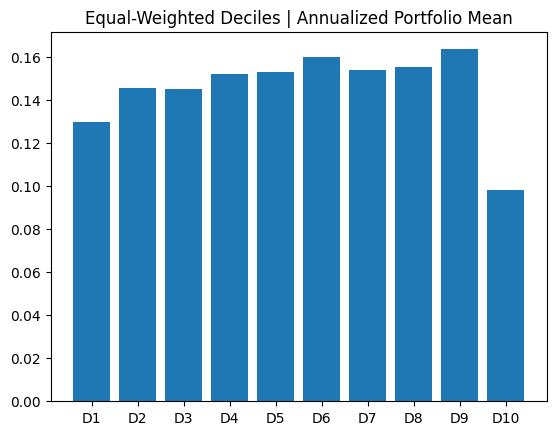

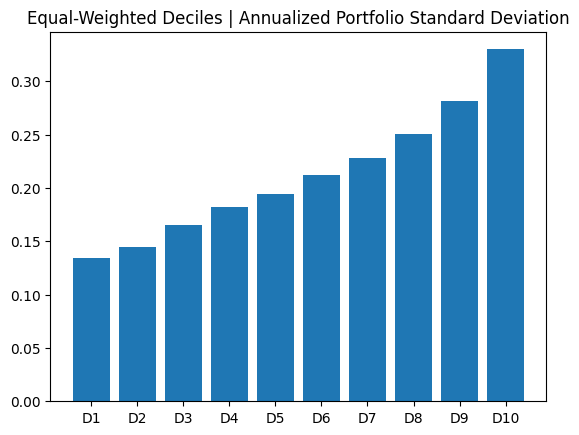

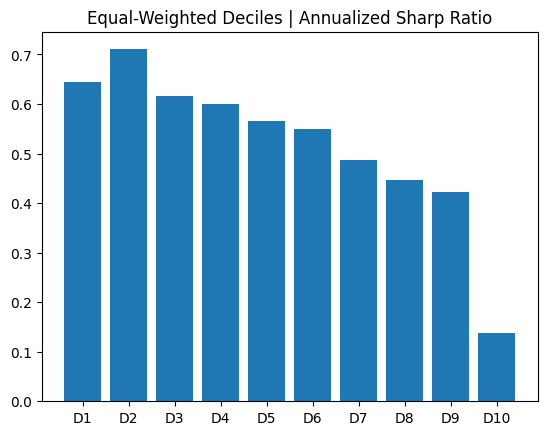

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Equal-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [11]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('beta_decile')['ew_decile_ret'].mean()*12),plt.title('Equal-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('beta_decile')['ew_decile_ret'].std()*np.sqrt(12)),plt.title('Equal-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('beta_decile')['ew_decile_excess_ret'].mean()*np.sqrt(12)/ret_ew.groupby('beta_decile')['ew_decile_ret'].std()),plt.title('Equal-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

#### Value Weighted

In [12]:
data_bab = data_bab.dropna(subset='beta').copy()
data_bab['beta_decile'] = data_bab.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

# Compute weights for value-weighted portfolios
data_bab['vw_decile'] = data_bab['mcap'] / data_bab.groupby(['date','beta_decile'])['mcap'].transform('sum')
# Compute returns for each portfolio
data_bab['vw_decile_ret'] = data_bab['vw_decile'] * data_bab['Rn']
data_bab['vw_decile_excess_ret'] = data_bab['vw_decile'] * data_bab['Rn_e']
ret_vw = data_bab.groupby(['date','beta_decile'])['vw_decile_ret'].sum().reset_index()
vw_decile_excess_ret = data_bab.groupby(['date', 'beta_decile'])['vw_decile_excess_ret'].sum().reset_index(name='vw_decile_excess_ret')
ret_vw = ret_vw.merge(vw_decile_excess_ret, on=['date', 'beta_decile'])
ret_vw

,date,beta_decile,vw_decile_ret,vw_decile_excess_ret
0,1967-01-31,0,0.071904,0.068116
1,1967-01-31,1,0.056307,0.052519
2,1967-01-31,2,0.059629,0.055841
3,1967-01-31,3,0.070514,0.066726
4,1967-01-31,4,0.109936,0.106148
...,...,...,...,...
6608,2023-12-29,5,0.081247,0.076762
6609,2023-12-29,6,0.093993,0.089509
6610,2023-12-29,7,0.111972,0.107488
6611,2023-12-29,8,0.125215,0.120731


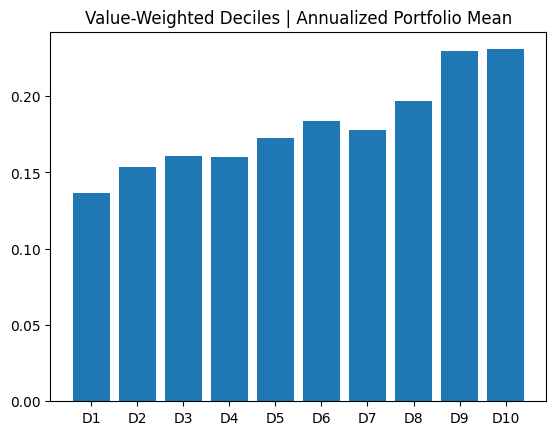

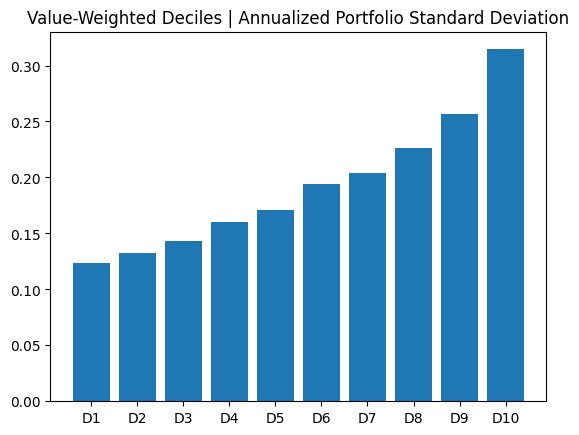

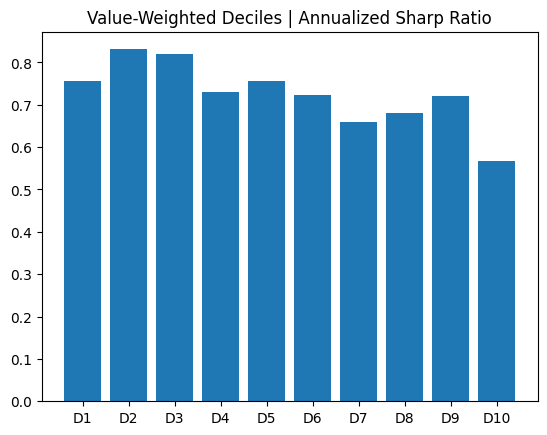

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Value-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [13]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('beta_decile')['vw_decile_ret'].mean()*12),plt.title('Value-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('beta_decile')['vw_decile_ret'].std()*np.sqrt(12)),plt.title('Value-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('beta_decile')['vw_decile_excess_ret'].mean()*np.sqrt(12)/ret_vw.groupby('beta_decile')['vw_decile_ret'].std()),plt.title('Value-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

### Constructing the BAB factor

In [14]:
# Compute z
data_bab['z'] = data_bab.groupby('date')['beta'].transform(lambda x: x.rank())
# Compute z-hat
data_bab['z_mean'] = data_bab.groupby('date')['z'].transform('mean')
# Calculate (z - z-hat)
data_bab['z_'] = data_bab['z'] - data_bab['z_mean']
# Calculate k
data_bab['k'] = np.abs(data_bab['z_'])
data_bab['k'] = 2/data_bab.groupby('date')['k'].transform('sum')
# Compute high-beta and low-beta portfolios weights
data_bab['w_H'] = data_bab['k'] * data_bab['z_'] * (data_bab['z_']>0) 
data_bab['w_L'] = -data_bab['k'] * data_bab['z_'] * (data_bab['z_']<0) 

In [15]:
# Compute betas
data_bab['beta_H'] = data_bab['w_H'] * data_bab['beta']
data_bab['beta_L'] = data_bab['w_L'] * data_bab['beta']
# Compute Excess Returns
data_bab['R_H_e'] = data_bab['w_H'] * data_bab['Rn_e']
data_bab['R_L_e'] = data_bab['w_L'] * data_bab['Rn_e']
# Sum up all returns and betas for each date
BAB = data_bab.groupby('date')[['R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()
# Compute BAB return
BAB['R_BAB'] = BAB['R_L_e']/BAB['beta_L'] - BAB['R_H_e']/BAB['beta_H'] 


In [16]:
tmp = pd.merge(BAB,data_bab[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['const'] = 1
tmp = tmp.dropna()
reg = sm.OLS(tmp['R_BAB'], tmp[['const', 'Rm_e']]).fit()

print('----------------------------------------')
print(f"| Annualized mean          | {np.round(tmp['R_BAB'].mean() * 12, 5)} |")
print(f"| Annualized std           | {np.round(tmp['R_BAB'].std() * np.sqrt(12), 5)}  |")
print(f"| Annualized Sharp Ratio   | {np.round(tmp['R_BAB'].mean() / tmp['R_BAB'].std() * np.sqrt(12), 5)} |")
print(f"| Annualized CAPM alpha    | {np.round(reg.params['const'] * 12, 5)} |")
print(f"| BAB factor               | {np.round(reg.params['Rm_e'], 5)} |")
print('----------------------------------------')

----------------------------------------
| Annualized mean          | 0.11618 |
| Annualized std           | 0.1399  |
| Annualized Sharp Ratio   | 0.83041 |
| Annualized CAPM alpha    | 0.08132 |
| BAB factor               | 0.51348 |
----------------------------------------


In [17]:
BAB_returns = tmp.set_index('date')['R_BAB']
BAB_returns

date
1967-01-31    0.070885
1967-02-28    0.017369
1967-03-31    0.005893
1967-04-28    0.019804
1967-05-31    0.003044
                ...   
2023-08-31   -0.012752
2023-09-29   -0.042908
2023-10-31    0.003602
2023-11-30    0.037597
2023-12-29    0.002342
Name: R_BAB, Length: 683, dtype: float64

## Momentum Strategy (Mom)

In [18]:
data_mom = pd.read_csv('data_with_siccd.csv', sep=',')
data_mom['date'] = pd.to_datetime(data_mom['date'])
data_mom=data_mom.sort_values(['date','permno']).reset_index(drop=True)
data_mom = data_mom.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()
data_mom['N'] = data_mom.groupby(['permno'])['date'].transform('count')
data_mom = data_mom[data_mom['N']>60].copy() # consider only those that have more than 5-years of data
data_mom.drop(columns=['Unnamed: 0'], inplace=True)
data_mom

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,N
0,10006,1964-01-31,10,1,3743,0.068548,2948.0,66.250,195305.000,202675.000,0.002873,0.025790,1,0.065675,0.022917,243
1,10014,1964-01-31,10,1,3714,0.000000,3369.0,2.875,9685.875,9685.875,0.002873,0.025790,1,-0.002873,0.022917,157
3,10057,1964-01-31,11,1,3541,0.069915,500.0,62.500,31250.000,33000.000,0.002873,0.025790,1,0.067042,0.022917,388
4,10102,1964-01-31,10,1,2813,0.029083,5032.0,57.500,289340.000,278018.000,0.002873,0.025790,1,0.026210,0.022917,170
5,10137,1964-01-31,11,1,4911,-0.007371,9338.0,50.500,471569.000,490245.000,0.002873,0.025790,1,-0.010244,0.022917,563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439403,93372,2023-12-29,11,1,3531,0.097182,22984.0,29.680,682165.120,720652.900,0.004484,0.053468,1,0.092698,0.048984,162
1439404,93373,2023-12-29,11,1,5621,-0.025611,3746.0,8.370,31354.020,37635.700,0.004484,0.053468,1,-0.030095,0.048984,162
1439405,93374,2023-12-29,11,1,6361,0.090101,103181.0,64.440,6648983.640,2896005.370,0.004484,0.053468,1,0.085617,0.048984,161
1439406,93423,2023-12-29,11,1,7389,0.007229,83537.0,25.080,2095107.960,2537102.050,0.004484,0.053468,1,0.002745,0.048984,161


### Portfolio Sorts

In [19]:
# Compute cumulative return for each permco
tmp = data_mom.set_index('date').groupby('permno')['Rn'].rolling(window=11, closed='left').apply(lambda x: (1 + x).prod() - 1).reset_index()
tmp = tmp.dropna()
tmp = tmp.reset_index().rename(columns={'Rn': 'lagged_11_month_ret'})
data_mom = pd.merge(data_mom, tmp, on=['date','permno'], how='left')
# Compute Deciles of returns for each date
data_mom['lagged_11_month_ret_decile'] = data_mom.groupby('date')['lagged_11_month_ret'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

#### Equally Weighted 

In [20]:
# Calculate weights for equal-weighted portfolios for date-decile pair
data_mom['ew_lagged_decile'] = 1 / data_mom.groupby(['date','lagged_11_month_ret_decile'])['permno'].transform('count')
# Compute returns of each portfolio
data_mom['ew_lagged_decile_ret'] = data_mom['ew_lagged_decile'] * data_mom['Rn']
data_mom['ew_lagged_decile_excess_ret'] = data_mom['ew_lagged_decile'] * data_mom['Rn_e']
ret_ew_lagged = data_mom.groupby(['date','lagged_11_month_ret_decile'])['ew_lagged_decile_ret'].sum().reset_index()
# Excess return
ew_lagged_decile_excess_ret = data_mom.groupby(['date', 'lagged_11_month_ret_decile'])['ew_lagged_decile_excess_ret'].sum().reset_index(name='ew_lagged_decile_excess_ret')
ret_ew_lagged = ret_ew_lagged.merge(ew_lagged_decile_excess_ret, on=['date', 'lagged_11_month_ret_decile'])
ret_ew_lagged

,date,lagged_11_month_ret_decile,ew_lagged_decile_ret,ew_lagged_decile_excess_ret
0,1964-12-31,0.0,-0.036680,-0.039536
1,1964-12-31,1.0,-0.011736,-0.014592
2,1964-12-31,2.0,-0.003629,-0.006485
3,1964-12-31,3.0,0.003942,0.001086
4,1964-12-31,4.0,-0.012312,-0.015167
...,...,...,...,...
7075,2023-12-29,5.0,0.068869,0.064385
7076,2023-12-29,6.0,0.075916,0.071432
7077,2023-12-29,7.0,0.073359,0.068874
7078,2023-12-29,8.0,0.096166,0.091681


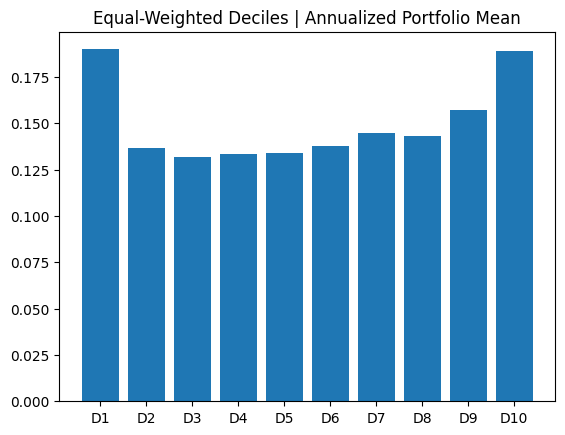

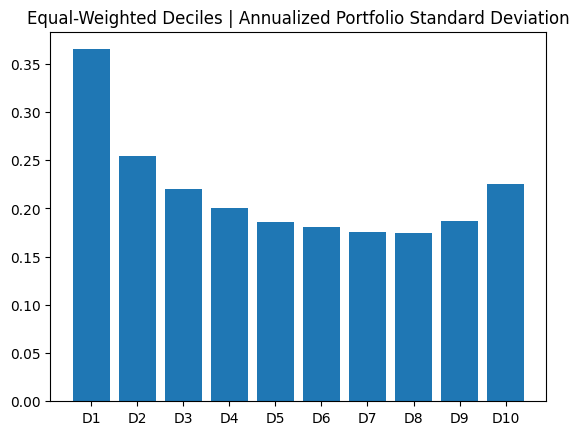

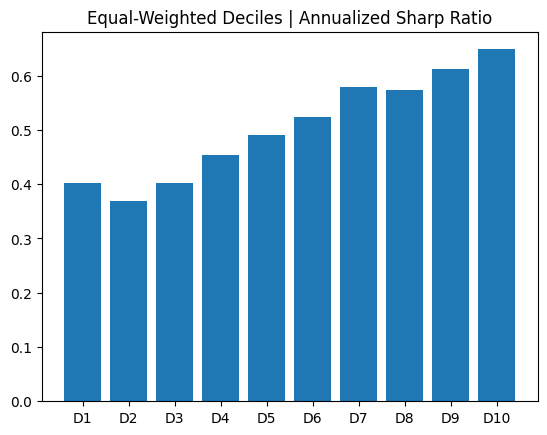

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Equal-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [21]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew_lagged.groupby('lagged_11_month_ret_decile')['ew_lagged_decile_ret'].mean()*12),plt.title('Equal-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew_lagged.groupby('lagged_11_month_ret_decile')['ew_lagged_decile_ret'].std()*np.sqrt(12)),plt.title('Equal-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew_lagged.groupby('lagged_11_month_ret_decile')['ew_lagged_decile_excess_ret'].mean()*np.sqrt(12)/ret_ew_lagged.groupby('lagged_11_month_ret_decile')['ew_lagged_decile_ret'].std()),plt.title('Equal-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

#### Value Weighted

In [22]:
# Compute weights for value-weighted portfolios
data_mom['vw_lagged_decile'] = data_mom['mcap'] / data_mom.groupby(['date','lagged_11_month_ret_decile'])['mcap'].transform('sum')
# Compute returns for each portfolio
data_mom['vw_lagged_decile_ret'] = data_mom['vw_lagged_decile'] * data_mom['Rn']
data_mom['vw_lagged_decile_excess_ret'] = data_mom['vw_lagged_decile'] * data_mom['Rn_e']
ret_vw_lagged = data_mom.groupby(['date','lagged_11_month_ret_decile'])['vw_lagged_decile_ret'].sum().reset_index()
vw_lagged_decile_excess_ret = data_mom.groupby(['date', 'lagged_11_month_ret_decile'])['vw_lagged_decile_excess_ret'].sum().reset_index(name='vw_lagged_decile_excess_ret')
ret_vw_lagged = ret_vw_lagged.merge(vw_lagged_decile_excess_ret, on=['date', 'lagged_11_month_ret_decile'])
ret_vw_lagged

,date,lagged_11_month_ret_decile,vw_lagged_decile_ret,vw_lagged_decile_excess_ret
0,1964-12-31,0.0,-0.004366,-0.007222
1,1964-12-31,1.0,0.004115,0.001259
2,1964-12-31,2.0,0.015191,0.012335
3,1964-12-31,3.0,0.012104,0.009248
4,1964-12-31,4.0,0.002737,-0.000119
...,...,...,...,...
7075,2023-12-29,5.0,0.024944,0.020459
7076,2023-12-29,6.0,0.045141,0.040657
7077,2023-12-29,7.0,0.040386,0.035902
7078,2023-12-29,8.0,0.079104,0.074619


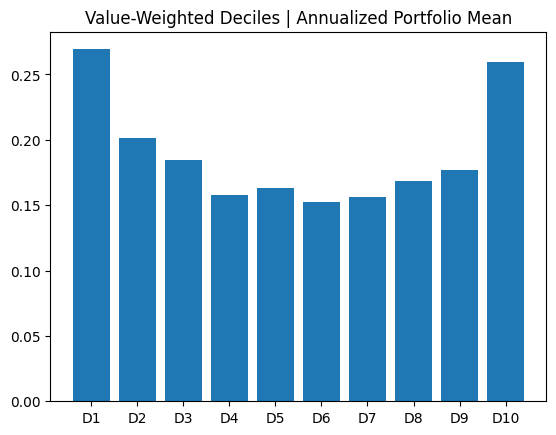

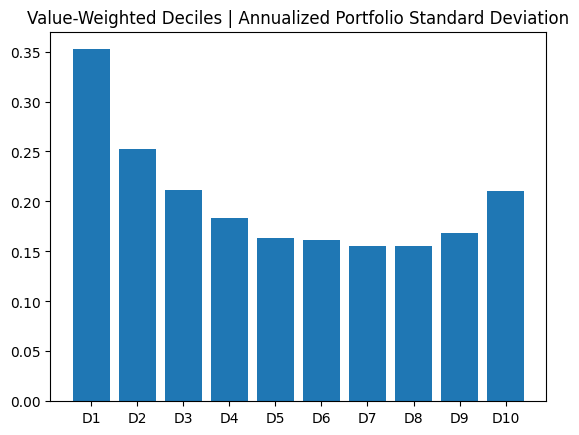

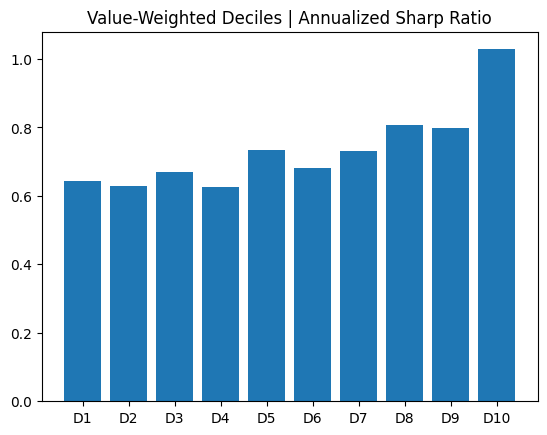

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Value-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [23]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw_lagged.groupby('lagged_11_month_ret_decile')['vw_lagged_decile_ret'].mean()*12),plt.title('Value-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw_lagged.groupby('lagged_11_month_ret_decile')['vw_lagged_decile_ret'].std()*np.sqrt(12)),plt.title('Value-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw_lagged.groupby('lagged_11_month_ret_decile')['vw_lagged_decile_excess_ret'].mean()*np.sqrt(12)/ret_vw_lagged.groupby('lagged_11_month_ret_decile')['vw_lagged_decile_ret'].std()),plt.title('Value-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

### Momentum Strategy Portfolio

In [24]:
def calculate_portfolio_metrics(returns, excess_returns):
    mean_return = returns.mean() * 12
    std_dev = returns.std() * np.sqrt(12)
    sharpe_ratio = excess_returns.mean() * 12 / std_dev
    return mean_return, std_dev, sharpe_ratio

In [25]:
long_mom = data_mom[data_mom['lagged_11_month_ret_decile'].isin([7,8,9])].copy()
short_mom = data_mom[data_mom['lagged_11_month_ret_decile'].isin([0,1,2])].copy()

#### Equally Weighted Portfolio

In [26]:
# long_mom portfolio: Equal-weighted average of the top three deciles (Deciles 7, 8 and 9)
ew_long_mom_rets = long_mom.groupby('date')['Rn'].mean() 
ew_long_mom_excess_rets = long_mom.groupby('date')['Rn_e'].mean() 
# short_mom portfolio: Equal-weighted average of the bottom three deciles (Deciles 0, 1 and 2)
ew_short_mom_rets = short_mom.groupby('date')['Rn'].mean() 
ew_short_mom_excess_rets = short_mom.groupby('date')['Rn_e'].mean() 
# Compute the return of the momentum strategy as the difference between the long_mom and short_mom portfolios' returns
ew_momentum_rets = ew_long_mom_rets - ew_short_mom_rets

In [27]:
ew_long_mom_mean, ew_long_mom_std, ew_long_mom_sharpe = calculate_portfolio_metrics(ew_long_mom_rets, ew_long_mom_excess_rets)
ew_short_mom_mean, ew_short_mom_std, ew_short_mom_sharpe = calculate_portfolio_metrics(ew_short_mom_rets, ew_short_mom_excess_rets)
ew_momentum_mean, ew_momentum_std, ew_momentum_sharpe = calculate_portfolio_metrics(ew_momentum_rets, ew_long_mom_excess_rets - ew_short_mom_excess_rets)
ew_t_stat, ew_p_value = stats.ttest_1samp(ew_momentum_rets, 0)

print(f"Equal-Weighted Portfolio Metrics:")
print(f"long_mom Portfolio: Mean = {ew_long_mom_mean:.3%}, Std Dev = {ew_long_mom_std:.3%}, Sharpe Ratio = {ew_long_mom_sharpe:.3f}")
print(f"short_mom Portfolio: Mean = {ew_short_mom_mean:.3%}, Std Dev = {ew_short_mom_std:.3%}, Sharpe Ratio = {ew_short_mom_sharpe:.3f}")
print(f"Momentum Strategy: Mean = {ew_momentum_mean:.3%}, Std Dev = {ew_momentum_std:.3%}, Sharpe Ratio = {ew_momentum_sharpe:.3f}")
print(f"T-statistic = {ew_t_stat:.2f}, P-value = {ew_p_value:.4f}\n")

Equal-Weighted Portfolio Metrics:
long_mom Portfolio: Mean = 16.324%, Std Dev = 19.121%, Sharpe Ratio = 0.629
short_mom Portfolio: Mean = 15.282%, Std Dev = 27.255%, Sharpe Ratio = 0.403
Momentum Strategy: Mean = 1.042%, Std Dev = 17.736%, Sharpe Ratio = 0.059
T-statistic = 0.45, P-value = 0.6519



#### Value Weighted Portfolio

In [28]:
# long_mom portfolio: Value-weighted average of the top three deciles (Deciles 7, 8 and 9)
long_mom_weights = long_mom['mcap'] / long_mom.groupby('date')['mcap'].transform('sum')
long_mom['vw_rets'] = long_mom_weights * long_mom['Rn']
vw_long_mom_rets = long_mom.groupby('date')['vw_rets'].sum()
long_mom['vw_excess_rets'] = long_mom_weights * long_mom['Rn_e']
vw_long_mom_excess_rets = long_mom.groupby('date')['vw_excess_rets'].sum()
# short_mom portfolio: Value-weighted average of the bottom three deciles (Deciles 0, 1 and 2)
short_mom_weights = short_mom['mcap'] / short_mom.groupby('date')['mcap'].transform('sum')
short_mom['vw_rets'] = short_mom_weights * short_mom['Rn']
vw_short_mom_rets = short_mom.groupby('date')['vw_rets'].sum()
short_mom['vw_excess_rets'] = short_mom_weights * short_mom['Rn_e']
vw_short_mom_excess_rets = short_mom.groupby('date')['vw_excess_rets'].sum()
# Compute the return of the momentum strategy as the difference between the long_mom and short_mom portfolios' returns
vw_momentum_rets = vw_long_mom_rets - vw_short_mom_rets

In [41]:
MOM_returns = vw_momentum_rets.copy()

In [29]:
vw_long_mom_mean, vw_long_mom_std, vw_long_mom_sharpe = calculate_portfolio_metrics(vw_long_mom_rets, vw_long_mom_excess_rets)
vw_short_mom_mean, vw_short_mom_std, vw_short_mom_sharpe = calculate_portfolio_metrics(vw_short_mom_rets, vw_short_mom_excess_rets)
vw_momentum_mean, vw_momentum_std, vw_momentum_sharpe = calculate_portfolio_metrics(vw_momentum_rets, vw_long_mom_excess_rets - vw_short_mom_excess_rets)
vw_t_stat, vw_p_value = stats.ttest_1samp(vw_momentum_rets, 0)

print(f"Value-Weighted Portfolio Metrics:")
print(f"long_mom Portfolio: Mean = {vw_long_mom_mean:.3%}, Std Dev = {vw_long_mom_std:.3%}, Sharpe Ratio = {vw_long_mom_sharpe:.3f}")
print(f"short_mom Portfolio: Mean = {vw_short_mom_mean:.3%}, Std Dev = {vw_short_mom_std:.3%}, Sharpe Ratio = {vw_short_mom_sharpe:.3f}")
print(f"Momentum Strategy: Mean = {vw_momentum_mean:.3%}, Std Dev = {vw_momentum_std:.3%}, Sharpe Ratio = {vw_momentum_sharpe:.3f}")
print(f"T-statistic = {vw_t_stat:.2f}, P-value = {vw_p_value:.4f}\n")

Value-Weighted Portfolio Metrics:
long_mom Portfolio: Mean = 18.924%, Std Dev = 16.260%, Sharpe Ratio = 0.899
short_mom Portfolio: Mean = 20.217%, Std Dev = 23.373%, Sharpe Ratio = 0.681
Momentum Strategy: Mean = -1.293%, Std Dev = 18.587%, Sharpe Ratio = -0.070
T-statistic = -0.53, P-value = 0.5933



## Idiosyncratic Volatility Strategy (IV)

In [42]:
data_iv = pd.read_csv('data_with_siccd.csv', sep=',')
data_iv['date'] = pd.to_datetime(data_iv['date'])
data_iv=data_iv.sort_values(['date','permno']).reset_index(drop=True)
data_iv = data_iv.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()
data_iv['N'] = data_iv.groupby(['permno'])['date'].transform('count')
data_iv = data_iv[data_iv['N']>60].copy() # consider only those that have more than 5-years of data
data_iv.drop(columns=['Unnamed: 0'], inplace=True)
data_iv

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,N
0,10006,1964-01-31,10,1,3743,0.068548,2948.0,66.250,195305.000,202675.000,0.002873,0.025790,1,0.065675,0.022917,243
1,10014,1964-01-31,10,1,3714,0.000000,3369.0,2.875,9685.875,9685.875,0.002873,0.025790,1,-0.002873,0.022917,157
3,10057,1964-01-31,11,1,3541,0.069915,500.0,62.500,31250.000,33000.000,0.002873,0.025790,1,0.067042,0.022917,388
4,10102,1964-01-31,10,1,2813,0.029083,5032.0,57.500,289340.000,278018.000,0.002873,0.025790,1,0.026210,0.022917,170
5,10137,1964-01-31,11,1,4911,-0.007371,9338.0,50.500,471569.000,490245.000,0.002873,0.025790,1,-0.010244,0.022917,563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439403,93372,2023-12-29,11,1,3531,0.097182,22984.0,29.680,682165.120,720652.900,0.004484,0.053468,1,0.092698,0.048984,162
1439404,93373,2023-12-29,11,1,5621,-0.025611,3746.0,8.370,31354.020,37635.700,0.004484,0.053468,1,-0.030095,0.048984,162
1439405,93374,2023-12-29,11,1,6361,0.090101,103181.0,64.440,6648983.640,2896005.370,0.004484,0.053468,1,0.085617,0.048984,161
1439406,93423,2023-12-29,11,1,7389,0.007229,83537.0,25.080,2095107.960,2537102.050,0.004484,0.053468,1,0.002745,0.048984,161


### Idiosyncratic volatility

In [43]:
window_size = 60 # 5-year rolling window
#Compute covariance matrix of excess stock and market returns
cov_nm = data_iv.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(window_size, min_periods=36).cov()
# Compute idiosyncratic risk from OLS regression (VAR(Rn_e) - COV(Rn_e, Rm_e)^2/VAR(Rm_e))
risk_idio = cov_nm.iloc[0::2,0].droplevel(2)
risk_idio = risk_idio.reset_index().rename(columns={'Rn_e': 'tot_risk_squared'})
risk_sys = cov_nm.iloc[0::2,1].droplevel(2) ** 2 / cov_nm.iloc[1::2,1].droplevel(2)
risk_sys = risk_sys.reset_index().rename(columns={'Rm_e': 'sys_risk_squared'})
risk_idio = pd.merge(risk_idio, risk_sys, on=['date','permno'], how='left')
risk_idio['idio_risk_squared'] = risk_idio['tot_risk_squared'] - risk_idio['sys_risk_squared']
risk_idio['idio_risk'] = np.sqrt(risk_idio['idio_risk_squared'])
risk_idio = risk_idio.drop(columns=['sys_risk_squared', 'idio_risk_squared', 'tot_risk_squared'])
# Merge idiosyncratic risk dataframe into data dataframe
risk_idio = risk_idio.set_index(['date', 'permno']).groupby('permno').shift(1)
risk_idio = risk_idio.dropna().reset_index()
data_iv = pd.merge(data_iv, risk_idio, on=['date','permno'], how='left')

# Winsorize the idiosyncratic risk at 5 and 95%
data_iv['idio_risk'] = data_iv['idio_risk'].clip(lower = data_iv['idio_risk'].quantile(0.05), upper = data_iv['idio_risk'].quantile(0.95))
data_iv = data_iv.dropna(subset='idio_risk').copy()
data_iv

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,N,idio_risk
58820,10006,1967-01-31,10,1,3743,0.140523,5748.0,43.625,250756.50,238542.00,0.003788,0.085530,1,0.136735,0.081742,243,0.044747
58821,10014,1967-01-31,10,1,3714,0.321429,3372.0,4.625,15595.50,15595.50,0.003788,0.085530,1,0.317641,0.081742,157,0.097687
58822,10057,1967-01-31,11,1,3541,0.146104,1014.0,44.125,44742.75,43348.50,0.003788,0.085530,1,0.142316,0.081742,388,0.056330
58823,10102,1967-01-31,10,1,2813,0.105364,5176.0,72.125,373319.00,380436.00,0.003788,0.085530,1,0.101576,0.081742,170,0.052335
58824,10137,1967-01-31,11,1,4911,-0.045045,19292.0,26.500,511238.00,511238.00,0.003788,0.085530,1,-0.048833,0.081742,563,0.044747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321748,93372,2023-12-29,11,1,3531,0.097182,22984.0,29.680,682165.12,720652.90,0.004484,0.053468,1,0.092698,0.048984,162,0.071300
1321749,93373,2023-12-29,11,1,5621,-0.025611,3746.0,8.370,31354.02,37635.70,0.004484,0.053468,1,-0.030095,0.048984,162,0.207290
1321750,93374,2023-12-29,11,1,6361,0.090101,103181.0,64.440,6648983.64,2896005.37,0.004484,0.053468,1,0.085617,0.048984,161,0.046390
1321751,93423,2023-12-29,11,1,7389,0.007229,83537.0,25.080,2095107.96,2537102.05,0.004484,0.053468,1,0.002745,0.048984,161,0.116407


### Portfolio Sorts

#### Equally Weighted

In [44]:
# Compute idio_risk decile for each date
data_iv['idio_risk_decile'] = data_iv.groupby('date')['idio_risk'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))
# Compute weight for equal-weight porfolio for each date-decile portfolio
data_iv['ew_decile'] = 1 / data_iv.groupby(['date','idio_risk_decile'])['permno'].transform('count')

# Compute weighted return of each portfolio
data_iv['ew_decile_ret'] = data_iv['ew_decile'] * data_iv['Rn']
data_iv['ew_decile_excess_ret'] = data_iv['ew_decile'] * data_iv['Rn_e']
ret_ew = data_iv.groupby(['date','idio_risk_decile'])['ew_decile_ret'].sum().reset_index()

# Compute excess return
ew_decile_excess_ret = data_iv.groupby(['date', 'idio_risk_decile'])['ew_decile_excess_ret'].sum().reset_index(name='ew_decile_excess_ret')
ret_ew = ret_ew.merge(ew_decile_excess_ret, on=['date', 'idio_risk_decile'])
ret_ew

,date,idio_risk_decile,ew_decile_ret,ew_decile_excess_ret
0,1967-01-31,0,0.085161,0.081373
1,1967-01-31,1,0.108426,0.104638
2,1967-01-31,2,0.136671,0.132883
3,1967-01-31,3,0.130669,0.126881
4,1967-01-31,4,0.160165,0.156377
...,...,...,...,...
6648,2023-12-29,4,0.107464,0.102979
6649,2023-12-29,5,0.115147,0.110663
6650,2023-12-29,6,0.138260,0.133776
6651,2023-12-29,7,0.091463,0.086978


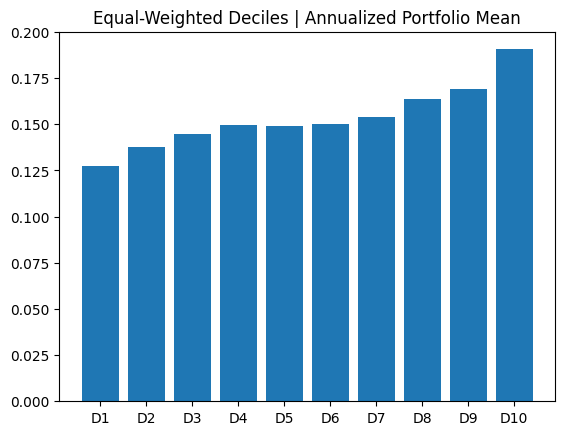

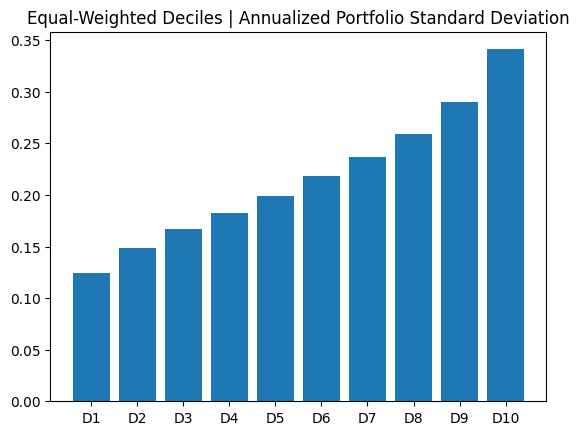

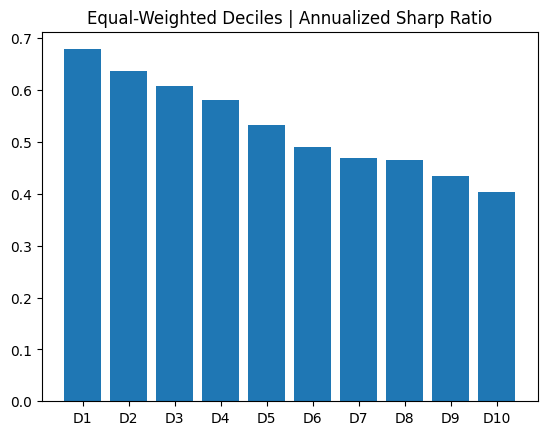

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Equal-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [45]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('idio_risk_decile')['ew_decile_ret'].mean()*12),plt.title('Equal-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('idio_risk_decile')['ew_decile_ret'].std()*np.sqrt(12)),plt.title('Equal-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('idio_risk_decile')['ew_decile_excess_ret'].mean()*np.sqrt(12)/ret_ew.groupby('idio_risk_decile')['ew_decile_ret'].std()),plt.title('Equal-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

#### Value Weighted

In [46]:
data_iv = data_iv.dropna(subset='idio_risk').copy()
data_iv['idio_risk_decile'] = data_iv.groupby('date')['idio_risk'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

# Compute weights for value-weighted portfolios
data_iv['vw_decile'] = data_iv['mcap'] / data_iv.groupby(['date','idio_risk_decile'])['mcap'].transform('sum')
# Compute returns for each portfolio
data_iv['vw_decile_ret'] = data_iv['vw_decile'] * data_iv['Rn']
data_iv['vw_decile_excess_ret'] = data_iv['vw_decile'] * data_iv['Rn_e']
ret_vw = data_iv.groupby(['date','idio_risk_decile'])['vw_decile_ret'].sum().reset_index()
vw_decile_excess_ret = data_iv.groupby(['date', 'idio_risk_decile'])['vw_decile_excess_ret'].sum().reset_index(name='vw_decile_excess_ret')
ret_vw = ret_vw.merge(vw_decile_excess_ret, on=['date', 'idio_risk_decile'])
ret_vw

,date,idio_risk_decile,vw_decile_ret,vw_decile_excess_ret
0,1967-01-31,0,0.067173,0.063385
1,1967-01-31,1,0.096155,0.092367
2,1967-01-31,2,0.101218,0.097430
3,1967-01-31,3,0.102107,0.098319
4,1967-01-31,4,0.124223,0.120435
...,...,...,...,...
6648,2023-12-29,4,0.054508,0.050024
6649,2023-12-29,5,0.092524,0.088039
6650,2023-12-29,6,0.090034,0.085549
6651,2023-12-29,7,0.095663,0.091178


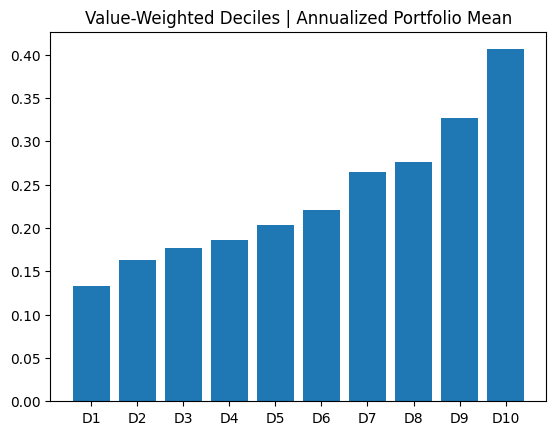

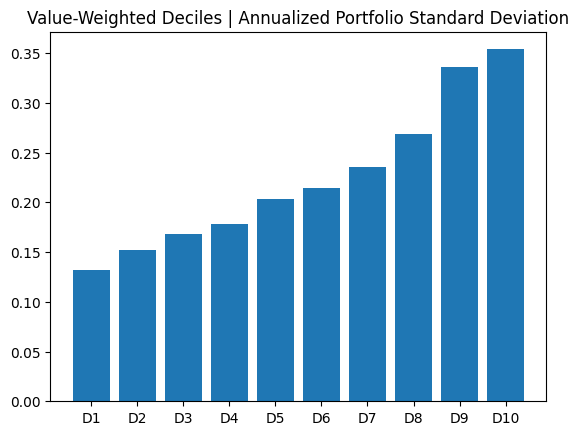

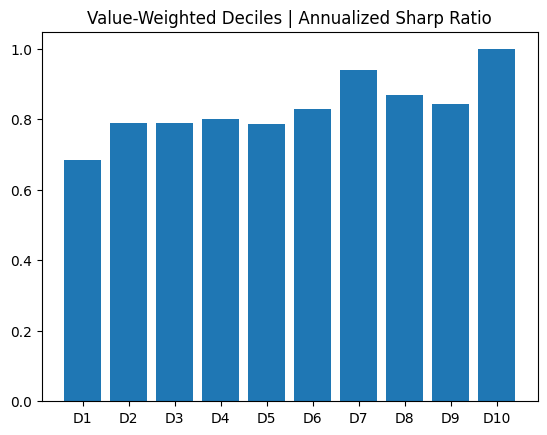

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Value-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [47]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('idio_risk_decile')['vw_decile_ret'].mean()*12),plt.title('Value-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('idio_risk_decile')['vw_decile_ret'].std()*np.sqrt(12)),plt.title('Value-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('idio_risk_decile')['vw_decile_excess_ret'].mean()*np.sqrt(12)/ret_vw.groupby('idio_risk_decile')['vw_decile_ret'].std()),plt.title('Value-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

### Idiosyncratic Volatility Portfolio

In [48]:
long_iv = data_iv[data_iv['idio_risk_decile'].isin([7,8,9])].copy()
short_iv = data_iv[data_iv['idio_risk_decile'].isin([0,1,2])].copy()

#### Equally Weighted Portfolio

In [49]:
# long_iv portfolio: Equal-weighted average of the top three deciles (Deciles 7, 8 and 9)
ew_long_iv_rets = long_iv.groupby('date')['Rn'].mean() 
ew_long_iv_excess_rets = long_iv.groupby('date')['Rn_e'].mean() 
# short_iv portfolio: Equal-weighted average of the bottom three deciles (Deciles 0, 1 and 2)
ew_short_iv_rets = short_iv.groupby('date')['Rn'].mean() 
ew_short_iv_excess_rets = short_iv.groupby('date')['Rn_e'].mean() 
# Compute the return of the iv strategy as the difference between the long_iv and short_iv portfolios' returns
ew_iv_rets = ew_long_iv_rets - ew_short_iv_rets

In [50]:
ew_long_iv_mean, ew_long_iv_std, ew_long_iv_sharpe = calculate_portfolio_metrics(ew_long_iv_rets, ew_long_iv_excess_rets)
ew_short_iv_mean, ew_short_iv_std, ew_short_iv_sharpe = calculate_portfolio_metrics(ew_short_iv_rets, ew_short_iv_excess_rets)
ew_iv_mean, ew_iv_std, ew_iv_sharpe = calculate_portfolio_metrics(ew_iv_rets, ew_long_iv_excess_rets - ew_short_iv_excess_rets)
ew_t_stat, ew_p_value = stats.ttest_1samp(ew_iv_rets, 0)

print(f"Equal-Weighted Portfolio Metrics:")
print(f"long_iv Portfolio: Mean = {ew_long_iv_mean:.3%}, Std Dev = {ew_long_iv_std:.3%}, Sharpe Ratio = {ew_long_iv_sharpe:.3f}")
print(f"short_iv Portfolio: Mean = {ew_short_iv_mean:.3%}, Std Dev = {ew_short_iv_std:.3%}, Sharpe Ratio = {ew_short_iv_sharpe:.3f}")
print(f"iv Strategy: Mean = {ew_iv_mean:.3%}, Std Dev = {ew_iv_std:.3%}, Sharpe Ratio = {ew_iv_sharpe:.3f}")
print(f"T-statistic = {ew_t_stat:.2f}, P-value = {ew_p_value:.4f}\n")

Equal-Weighted Portfolio Metrics:
long_iv Portfolio: Mean = 16.858%, Std Dev = 28.443%, Sharpe Ratio = 0.441
short_iv Portfolio: Mean = 13.645%, Std Dev = 14.274%, Sharpe Ratio = 0.654
iv Strategy: Mean = 3.213%, Std Dev = 19.555%, Sharpe Ratio = 0.164
T-statistic = 1.24, P-value = 0.2156



#### Value Weighted Portfolio

In [51]:
# long_iv portfolio: Value-weighted average of the top three deciles (Deciles 7, 8 and 9)
long_iv_weights = long_iv['mcap'] / long_iv.groupby('date')['mcap'].transform('sum')
long_iv['vw_rets'] = long_iv_weights * long_iv['Rn']
vw_long_iv_rets = long_iv.groupby('date')['vw_rets'].sum()
long_iv['vw_excess_rets'] = long_iv_weights * long_iv['Rn_e']
vw_long_iv_excess_rets = long_iv.groupby('date')['vw_excess_rets'].sum()
# short_iv portfolio: Value-weighted average of the bottom three deciles (Deciles 0, 1 and 2)
short_iv_weights = short_iv['mcap'] / short_iv.groupby('date')['mcap'].transform('sum')
short_iv['vw_rets'] = short_iv_weights * short_iv['Rn']
vw_short_iv_rets = short_iv.groupby('date')['vw_rets'].sum()
short_iv['vw_excess_rets'] = short_iv_weights * short_iv['Rn_e']
vw_short_iv_excess_rets = short_iv.groupby('date')['vw_excess_rets'].sum()
# Compute the return of the iv strategy as the difference between the long_iv and short_iv portfolios' returns
vw_iv_rets = vw_long_iv_rets - vw_short_iv_rets

In [52]:
IV_returns = vw_iv_rets.copy()

In [53]:
vw_long_iv_mean, vw_long_iv_std, vw_long_iv_sharpe = calculate_portfolio_metrics(vw_long_iv_rets, vw_long_iv_excess_rets)
vw_short_iv_mean, vw_short_iv_std, vw_short_iv_sharpe = calculate_portfolio_metrics(vw_short_iv_rets, vw_short_iv_excess_rets)
vw_iv_mean, vw_iv_std, vw_iv_sharpe = calculate_portfolio_metrics(vw_iv_rets, vw_long_iv_excess_rets - vw_short_iv_excess_rets)
vw_t_stat, vw_p_value = stats.ttest_1samp(vw_iv_rets, 0)

print(f"Value-Weighted Portfolio Metrics:")
print(f"long_iv Portfolio: Mean = {vw_long_iv_mean:.3%}, Std Dev = {vw_long_iv_std:.3%}, Sharpe Ratio = {vw_long_iv_sharpe:.3f}")
print(f"short_iv Portfolio: Mean = {vw_short_iv_mean:.3%}, Std Dev = {vw_short_iv_std:.3%}, Sharpe Ratio = {vw_short_iv_sharpe:.3f}")
print(f"iv Strategy: Mean = {vw_iv_mean:.3%}, Std Dev = {vw_iv_std:.3%}, Sharpe Ratio = {vw_iv_sharpe:.3f}")
print(f"T-statistic = {vw_t_stat:.2f}, P-value = {vw_p_value:.4f}\n")

Value-Weighted Portfolio Metrics:
long_iv Portfolio: Mean = 30.647%, Std Dev = 28.312%, Sharpe Ratio = 0.930
short_iv Portfolio: Mean = 14.980%, Std Dev = 13.963%, Sharpe Ratio = 0.765
iv Strategy: Mean = 15.667%, Std Dev = 21.069%, Sharpe Ratio = 0.744
T-statistic = 5.61, P-value = 0.0000



## Optimal Fund Portfolio Return (STRAT)

In [54]:
IV_returns = pd.DataFrame(IV_returns)
MOM_returns = pd.DataFrame(MOM_returns)

In [56]:
IV_returns.rename(columns = {'vw_rets':'R_IV'}, inplace = True)
MOM_returns.rename(columns = {'vw_rets':'R_MOM'}, inplace = True)

In [196]:
returns = pd.merge(BAB_returns, IV_returns, on='date', how='inner')
returns = pd.merge(returns, MOM_returns, on='date', how='inner')
returns = pd.merge(returns, data_bab[['date','rf']].drop_duplicates(), on='date', how='inner')
returns

,date,R_BAB,R_IV,R_MOM,rf
0,1967-01-31,0.070885,0.159371,0.159371,0.003788
1,1967-02-28,0.017369,0.035770,0.035770,0.003737
2,1967-03-31,0.005893,0.014321,0.014321,0.003385
3,1967-04-28,0.019804,0.028545,0.028545,0.002877
4,1967-05-31,0.003044,0.024710,0.024710,0.002707
...,...,...,...,...,...
678,2023-08-31,-0.012752,-0.003425,-0.003425,0.004463
679,2023-09-29,-0.042908,0.022047,0.022047,0.004472
680,2023-10-31,0.003602,-0.024331,-0.024331,0.004475
681,2023-11-30,0.037597,-0.000303,-0.000303,0.004455


#### Equally Weighted Portfolio

In [197]:
returns['EW_BAB_weight'] = 1/3
returns['EW_IV_weight'] = 1/3
returns['EW_MOM_weight'] = 1/3
returns['EW'] = returns['EW_BAB_weight'] * returns['R_BAB'] + returns['EW_IV_weight'] * returns['R_IV'] + returns['EW_MOM_weight'] * returns['R_MOM'] + (1/3) * returns['rf']

In [198]:
c = 0.1 / returns['EW'].std()
returns['EW_BAB_weight'] = c * returns['EW_BAB_weight']
returns['EW_IV_weight'] = c * returns['EW_IV_weight']
returns['EW_MOM_weight'] = c * returns['EW_MOM_weight']
returns['EW'] = returns['EW_BAB_weight'] * returns['R_BAB'] + returns['EW_IV_weight'] * returns['R_IV'] + returns['EW_MOM_weight'] * returns['R_MOM'] + (1 - c) * returns['rf']

In [199]:
# Define the rolling window size
window_size = 60

# Calculate the rolling standard deviation of each strategy's returns
returns['R_BAB_vol'] = returns['R_BAB'].rolling(window_size).std()
returns['R_IV_vol'] = returns['R_IV'].rolling(window_size).std()
returns['R_MOM_vol'] = returns['R_MOM'].rolling(window_size).std()

# Calculate the inverse volatilities
returns['R_BAB_inv_vol'] = 1 / returns['R_BAB_vol']
returns['R_IV_inv_vol'] = 1 / returns['R_IV_vol']
returns['R_MOM_inv_vol'] = 1 / returns['R_MOM_vol']

# Calculate the sum of the inverse volatilities
returns['inv_vol_sum'] = returns[['R_BAB_inv_vol', 'R_IV_inv_vol', 'R_MOM_inv_vol']].sum(axis=1)

# Calculate the risk parity weights
returns['RP_BAB_weight'] = returns['R_BAB_inv_vol'] / returns['inv_vol_sum']
returns['RP_IV_weight'] = returns['R_IV_inv_vol'] / returns['inv_vol_sum']
returns['RP_MOM_weight'] = returns['R_MOM_inv_vol'] / returns['inv_vol_sum']

# Drop the intermediate columns
returns.drop(columns=['R_BAB_vol', 'R_IV_vol', 'R_MOM_vol', 'R_BAB_inv_vol', 'R_IV_inv_vol', 'R_MOM_inv_vol', 'inv_vol_sum'], inplace=True)



In [200]:
# Calculate the optimal fund portfolio return
returns['RP'] = returns['RP_BAB_weight'] * returns['R_BAB'] + returns['RP_IV_weight'] * returns['R_IV'] + returns['RP_MOM_weight'] * returns['R_MOM']

In [201]:
c = 0.1 / returns['RP'].std()
returns['RP_BAB_weight'] = c * returns['RP_BAB_weight']
returns['RP_IV_weight'] = c * returns['RP_IV_weight']
returns['RP_MOM_weight'] = c * returns['RP_MOM_weight']
returns['RP'] = returns['RP_BAB_weight'] * returns['R_BAB'] + returns['RP_IV_weight'] * returns['R_IV'] + returns['RP_MOM_weight'] * returns['R_MOM'] + (1 - c) * returns['rf']

In [202]:
import numpy as np

# Define the rolling window size
window_size = 60

# Calculate the rolling mean of each strategy's returns
returns['R_BAB_excess_mean'] = returns['R_BAB'].rolling(window_size).mean() - returns['rf']
returns['R_IV_excess_mean'] = returns['R_IV'].rolling(window_size).mean() - returns['rf']
returns['R_MOM_excess_mean'] = returns['R_MOM'].rolling(window_size).mean() - returns['rf']

# Calculate the rolling covariance matrix of the strategy returns
returns_cov = returns[['R_BAB', 'R_IV', 'R_MOM']].rolling(window_size).cov()

# For each date, calculate the MVE weights by multiplying the inverse of the covariance matrix with the mean returns
jitter = 1e-6  # Small constant

weights = returns_cov.groupby(level=0).apply(lambda x: np.linalg.inv(x.values + np.eye(x.values.shape[0]) * jitter) @ np.array([returns.loc[x.index[0][0], 'R_BAB_excess_mean'], returns.loc[x.index[0][0], 'R_IV_excess_mean'], returns.loc[x.index[0][0], 'R_MOM_excess_mean']]))

returns.drop(columns=['R_BAB_excess_mean', 'R_IV_excess_mean', 'R_MOM_excess_mean'], inplace=True)
# Normalize the weights so they sum to 1


In [203]:
weights = pd.DataFrame(weights.values.tolist(), index=weights.index, columns=['BAB_MVE_weights', 'IV_MVE_weights', 'MOM_MVE_weights'])

In [204]:
weights = weights.div(weights.sum(axis=1), axis=0)

In [205]:
weights.tail()

,BAB_MVE_weights,IV_MVE_weights,MOM_MVE_weights
678,3.756304,-1.378152,-1.378152
679,3.120969,-1.060484,-1.060484
680,5.356919,-2.178459,-2.178459
681,14.647619,-6.823810,-6.823810
682,-1.421098,1.210549,1.210549


In [206]:
# Add the calculated weights to the DataFrame
returns['MVE_BAB_weight'] = weights.iloc[:, 0]
returns['MVE_IV_weight'] = weights.iloc[:, 1]
returns['MVE_MOM_weight'] = weights.iloc[:, 2]

In [207]:
returns['MVE'] = returns['MVE_BAB_weight'] * returns['R_BAB'] + returns['MVE_IV_weight'] * returns['R_IV'] + returns['MVE_MOM_weight'] * returns['R_MOM']

In [208]:
c = 0.1 / returns['RP'].std()
returns['MVE_BAB_weight'] = c * returns['MVE_BAB_weight']
returns['MVE_IV_weight'] = c * returns['MVE_IV_weight']
returns['MVE_MOM_weight'] = c * returns['MVE_MOM_weight']
returns['MVE'] = returns['MVE_BAB_weight'] * returns['R_BAB'] + returns['MVE_IV_weight'] * returns['R_IV'] + returns['MVE_MOM_weight'] * returns['R_MOM'] + (1 - c) * returns['rf']

In [209]:
returns

,date,R_BAB,R_IV,R_MOM,rf,EW_BAB_weight,EW_IV_weight,EW_MOM_weight,EW,RP_BAB_weight,RP_IV_weight,RP_MOM_weight,RP,MVE_BAB_weight,MVE_IV_weight,MVE_MOM_weight,MVE
0,1967-01-31,0.070885,0.159371,0.159371,0.003788,0.747359,0.747359,0.747359,0.286487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1967-02-28,0.017369,0.035770,0.035770,0.003737,0.747359,0.747359,0.747359,0.061805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1967-03-31,0.005893,0.014321,0.014321,0.003385,0.747359,0.747359,0.747359,0.021606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1967-04-28,0.019804,0.028545,0.028545,0.002877,0.747359,0.747359,0.747359,0.053893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1967-05-31,0.003044,0.024710,0.024710,0.002707,0.747359,0.747359,0.747359,0.035846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,2023-08-31,-0.012752,-0.003425,-0.003425,0.004463,0.747359,0.747359,0.747359,-0.020194,1.446744,0.541845,0.541845,-0.028992,3.740464,-1.372340,-1.372340,-0.038281
679,2023-09-29,-0.042908,0.022047,0.022047,0.004472,0.747359,0.747359,0.747359,-0.004667,1.440037,0.545199,0.545199,-0.044592,3.107807,-1.056012,-1.056012,-0.179894
680,2023-10-31,0.003602,-0.024331,-0.024331,0.004475,0.747359,0.747359,0.747359,-0.039235,1.443789,0.543323,0.543323,-0.028087,5.334328,-2.169273,-2.169273,0.124796
681,2023-11-30,0.037597,-0.000303,-0.000303,0.004455,0.747359,0.747359,0.747359,0.022112,1.434951,0.547742,0.547742,0.046800,14.585849,-6.795033,-6.795033,0.552509


In [210]:
EW_mean, EW_std, EW_sharpe = calculate_portfolio_metrics(returns['EW'], returns['EW'] - returns['rf'])
RP_mean, RP_std, RP_sharpe = calculate_portfolio_metrics(returns['RP'], returns['RP'] - returns['rf'])
MVE_mean, MVE_std, MVE_sharpe = calculate_portfolio_metrics(returns['MVE'], returns['MVE'] - returns['rf'])

print(f"Equally Weighted Portfolio Metrics:")
print(f"Mean = {EW_mean:.2%}, Std Dev = {EW_std:.2%}, Sharpe Ratio = {EW_sharpe:.2f}\n")
print(f"Risk Parity Portfolio Metrics:")
print(f"Mean = {RP_mean:.2%}, Std Dev = {RP_std:.2%}, Sharpe Ratio = {RP_sharpe:.2f}\n")
print(f"Mean-Variance Efficient Portfolio Metrics:")
print(f"Mean = {MVE_mean:.2%}, Std Dev = {MVE_std:.2%}, Sharpe Ratio = {MVE_sharpe:.2f}\n")

Equally Weighted Portfolio Metrics:
Mean = 26.76%, Std Dev = 34.81%, Sharpe Ratio = 0.65

Risk Parity Portfolio Metrics:
Mean = 28.59%, Std Dev = 34.79%, Sharpe Ratio = 0.70

Mean-Variance Efficient Portfolio Metrics:
Mean = -5.05%, Std Dev = 104.40%, Sharpe Ratio = -0.09



## Performance and risk analysis for the Fund strategy

### a)

In [77]:
new_returns = returns[['RP', 'date']]
new_returns['date'] = new_returns['date'].apply(lambda x: x.strftime('%Y-%m'))
new_returns['date'] = pd.to_datetime(new_returns['date'])
new_returns = new_returns.set_index('date')
# drop nan values
new_returns = new_returns.dropna()
new_returns.index

C:\Users\Amirmahdi\AppData\Local\Temp\ipykernel_3680\3728675472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_returns['date'] = new_returns['date'].apply(lambda x: x.strftime('%Y-%m'))
C:\Users\Amirmahdi\AppData\Local\Temp\ipykernel_3680\3728675472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_returns['date'] = pd.to_datetime(new_returns['date'])


DatetimeIndex(['1972-01-01', '1972-02-01', '1972-03-01', '1972-04-01',
               '1972-05-01', '1972-06-01', '1972-07-01', '1972-08-01',
               '1972-09-01', '1972-10-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='date', length=624, freq=None)

In [78]:
# read the Fama French factors
ff_factors = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows=3, sep=',')
ff_factors = ff_factors.iloc[:729]
ff_factors = ff_factors.rename(columns={'Unnamed: 0': 'date'})
ff_factors['date'] = pd.to_datetime(ff_factors['date'], format='%Y%m')
ff_factors = ff_factors.set_index('date')
ff_factors = ff_factors.astype(float)
ff_factors = ff_factors / 100
ff_factors

,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,
1963-07-01,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027
1963-08-01,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025
1963-09-01,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027
1963-10-01,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029
1963-11-01,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027
...,...,...,...,...,...,...
2023-11-01,0.0884,-0.0012,0.0164,-0.0391,-0.0100,0.0044
2023-12-01,0.0487,0.0732,0.0493,-0.0307,0.0132,0.0043
2024-01-01,0.0070,-0.0574,-0.0238,0.0069,-0.0096,0.0047


In [170]:
# Read the industry_reuturns Portfolios data
# Import data
industry_reuturns = pd.read_csv("monthly_12_industries_portfolios.csv",sep=";")
industry_reuturns['Date'] = pd.to_datetime(industry_reuturns['Date'], format='%Y%m')  # First, ensure that "date" is in datetime format
industry_reuturns = industry_reuturns.set_index('Date')  # Then, set the index to be the date
industry_reuturns = industry_reuturns / 100  # Convert the data to decimal format
industry_reuturns

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
Date,,,,,,,,,,,,
1926-07-01,0.0145,0.1555,0.0367,-0.0118,0.0801,0.0316,0.0083,0.0704,0.0011,0.0177,-0.0002,0.0222
1926-08-01,0.0397,0.0368,0.0242,0.0347,0.0514,0.0197,0.0217,-0.0169,-0.0071,0.0425,0.0447,0.0434
1926-09-01,0.0114,0.0480,-0.0007,-0.0339,0.0530,-0.0034,0.0241,0.0204,0.0021,0.0069,-0.0161,0.0037
1926-10-01,-0.0124,-0.0823,-0.0316,-0.0078,-0.0455,-0.0538,-0.0011,-0.0263,-0.0229,-0.0057,-0.0551,-0.0273
1926-11-01,0.0520,-0.0019,0.0382,0.0001,0.0511,0.0479,0.0163,0.0371,0.0643,0.0542,0.0234,0.0210
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01,0.0353,0.0661,0.0783,0.0018,0.0285,0.0466,0.0226,0.0169,0.0590,0.0690,0.0677,0.0634
2024-01-01,-0.0177,-0.1791,-0.0194,-0.0011,0.0056,0.0311,0.0453,-0.0300,0.0128,0.0352,0.0072,0.0129
2024-02-01,0.0192,0.0721,0.0613,0.0295,0.0316,0.0611,-0.0272,0.0243,0.0946,0.0463,0.0364,0.0660


In [80]:
data = pd.merge(new_returns, ff_factors, left_index=True, right_index=True, how='inner')
data = pd.merge(data, industry_reuturns, left_index=True, right_index=True, how='inner')
data

,RP,Mkt-RF,SMB,HML,RMW,CMA,RF,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
1972-01-01,0.172306,0.0249,0.0610,0.0224,-0.0169,0.0055,0.0029,0.0250,0.0323,0.0306,0.0016,0.0370,0.0841,0.0094,-0.0030,0.0044,0.0260,0.0077,0.0619
1972-02-01,0.037065,0.0287,0.0087,-0.0279,0.0161,-0.0052,0.0025,0.0464,0.0084,0.0510,0.0261,0.0484,0.0172,0.0016,-0.0250,0.0565,0.0713,0.0002,0.0459
1972-03-01,-0.026227,0.0063,-0.0043,-0.0161,0.0163,-0.0018,0.0027,0.0009,0.0423,0.0265,-0.0546,0.0214,0.0103,-0.0032,-0.0015,0.0198,0.0046,0.0519,-0.0054
1972-04-01,-0.015923,0.0029,0.0023,0.0012,-0.0042,-0.0103,0.0029,0.0192,-0.0053,0.0196,-0.0069,0.0199,0.0076,-0.0105,-0.0281,-0.0056,0.0108,0.0259,0.0100
1972-05-01,-0.028188,0.0125,-0.0310,-0.0270,0.0234,-0.0195,0.0030,0.0041,-0.0100,0.0163,0.0365,0.0265,0.0375,0.0119,-0.0017,0.0158,0.0352,-0.0188,0.0071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,-0.028992,-0.0239,-0.0365,-0.0106,0.0343,-0.0237,0.0045,-0.0377,-0.0431,-0.0221,0.0195,-0.0275,-0.0167,0.0014,-0.0529,-0.0040,-0.0022,-0.0361,-0.0298
2023-09-01,-0.044592,-0.0524,-0.0180,0.0152,0.0186,-0.0083,0.0043,-0.0457,-0.0258,-0.0730,0.0317,-0.0657,-0.0595,-0.0322,-0.0504,-0.0568,-0.0471,-0.0204,-0.0557
2023-10-01,-0.028087,-0.0319,-0.0405,0.0018,0.0247,-0.0065,0.0047,-0.0353,-0.1788,-0.0301,-0.0624,-0.0221,-0.0173,-0.0018,0.0112,0.0047,-0.0458,-0.0178,-0.0378
2023-11-01,0.046800,0.0884,-0.0012,0.0164,-0.0391,-0.0100,0.0044,0.0502,0.1576,0.0973,-0.0129,0.0628,0.1194,0.0697,0.0508,0.0718,0.0587,0.1025,0.1073


In [81]:
import statsmodels.api as sm

# Assuming data is your DataFrame
y = data['RP']
X = data.drop(columns='RP')
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

# Print the coefficients and t-statistics
for column in X.columns:
    print(f"For {column}, coefficient: {results.params[column]}, t-stat: {results.tvalues[column]}")

# Print the R-squared value
print(f"R-squared: {results.rsquared}")

For const, coefficient: 0.022705239547564898, t-stat: 6.214583557743243
For Mkt-RF, coefficient: 0.2138624145842868, t-stat: 0.49292863824107397
For SMB, coefficient: 1.3713654857086293, t-stat: 14.65652389188936
For HML, coefficient: 0.21225551523930336, t-stat: 1.5246232479164799
For RMW, coefficient: -0.4585735085528214, t-stat: -3.392219748682467
For CMA, coefficient: 0.12282371769345998, t-stat: 0.7162276248246199
For RF, coefficient: -3.2277125182352906, t-stat: -3.673228884860423
For NoDur, coefficient: -0.11327414506754235, t-stat: -0.9093669077841386
For Durbl, coefficient: 0.09961368339814511, t-stat: 1.990569925367318
For Manuf, coefficient: 0.26450110617346634, t-stat: 1.9267857567641833
For Enrgy, coefficient: 0.12459938444102152, t-stat: 2.114067918581089
For Chems, coefficient: -0.29554426811470125, t-stat: -2.5796228126302676
For BusEq, coefficient: 0.43457793319086246, t-stat: 4.243101675849351
For Telcm, coefficient: -0.034520665336260775, t-stat: -0.4526717475004267


### b)

#### i)calculating stock weights in BAB

In [82]:
stock_data_bab = data_bab.copy()
aggregate_data_bab = BAB.copy()

In [83]:
aggregate_data_bab.rename(columns={'beta_H': 'beta_H_agg', 'beta_L': 'beta_L_agg'}, inplace=True)
aggregate_data_bab

,date,R_H_e,R_L_e,beta_H_agg,beta_L_agg,R_BAB
0,1967-01-31,0.212902,0.117049,1.905996,0.641063,0.070885
1,1967-02-28,0.043405,0.027223,2.035122,0.703490,0.017369
2,1967-03-31,0.075932,0.030037,2.032184,0.694366,0.005893
3,1967-04-28,0.045937,0.029146,2.030595,0.686977,0.019804
4,1967-05-31,-0.015546,-0.003168,2.014439,0.677846,0.003044
...,...,...,...,...,...,...
678,2023-08-31,-0.063537,-0.031035,1.850332,0.659050,-0.012752
679,2023-09-29,-0.054446,-0.047921,1.854743,0.663154,-0.042908
680,2023-10-31,-0.078978,-0.026037,1.841509,0.662779,0.003602
681,2023-11-30,0.074733,0.051839,1.842790,0.663316,0.037597


In [84]:
aggregate_data_bab = aggregate_data_bab[['date', 'beta_H_agg', 'beta_L_agg']]

In [85]:
epsilon = 1e-8
# Merge data_bab and BAB on 'date'
BAB_weights = pd.merge(stock_data_bab, aggregate_data_bab, on='date', how='left')

# Create new column
BAB_weights['weight_in_BAB'] = - BAB_weights['w_H'] / BAB_weights['beta_H_agg'] + BAB_weights['w_L'] / BAB_weights['beta_L_agg']

BAB_weights

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,...,k,w_H,w_L,beta_H,beta_L,R_H_e,R_L_e,beta_H_agg,beta_L_agg,weight_in_BAB
0,10006,1967-01-31,10,1,3743,0.140523,5748.0,43.625,250756.50,238542.00,...,0.000005,0.000715,-0.000000,0.000982,-0.000000,0.000098,-0.000000,1.905996,0.641063,-0.000375
1,10014,1967-01-31,10,1,3714,0.321429,3372.0,4.625,15595.50,15595.50,...,0.000005,0.000229,-0.000000,0.000285,-0.000000,0.000073,-0.000000,1.905996,0.641063,-0.000120
2,10057,1967-01-31,11,1,3541,0.146104,1014.0,44.125,44742.75,43348.50,...,0.000005,0.001197,-0.000000,0.001828,-0.000000,0.000170,-0.000000,1.905996,0.641063,-0.000628
3,10102,1967-01-31,10,1,2813,0.105364,5176.0,72.125,373319.00,380436.00,...,0.000005,0.000532,-0.000000,0.000707,-0.000000,0.000054,-0.000000,1.905996,0.641063,-0.000279
4,10137,1967-01-31,11,1,4911,-0.045045,19292.0,26.500,511238.00,511238.00,...,0.000005,-0.000000,0.002385,-0.000000,0.001471,0.000000,-0.000116,1.905996,0.641063,0.003720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109348,93372,2023-12-29,11,1,3531,0.097182,22984.0,29.680,682165.12,720652.90,...,0.000008,-0.000000,0.000583,-0.000000,0.000637,-0.000000,0.000054,1.815104,0.647428,0.000900
1109349,93373,2023-12-29,11,1,5621,-0.025611,3746.0,8.370,31354.02,37635.70,...,0.000008,0.003455,-0.000000,0.007575,-0.000000,-0.000104,0.000000,1.815104,0.647428,-0.001903
1109350,93374,2023-12-29,11,1,6361,0.090101,103181.0,64.440,6648983.64,2896005.37,...,0.000008,0.000305,-0.000000,0.000379,-0.000000,0.000026,-0.000000,1.815104,0.647428,-0.000168
1109351,93423,2023-12-29,11,1,7389,0.007229,83537.0,25.080,2095107.96,2537102.05,...,0.000008,0.003400,-0.000000,0.007288,-0.000000,0.000009,-0.000000,1.815104,0.647428,-0.001873


#### ii) calculating stock weights in MOM

In [86]:
long_portfolio = long_mom.copy()[['date', 'permno']]
long_weights = pd.DataFrame(long_mom_weights)
long_weights.rename(columns={'mcap':'weight_in_long_MOM'}, inplace=True)
long_portfolio = pd.concat([long_portfolio, long_weights], axis = 1)
long_portfolio

,date,permno,weight_in_long_MOM
16911,1964-12-31,10006,0.002379
16913,1964-12-31,10057,0.000349
16917,1964-12-31,10153,0.001804
16921,1964-12-31,10225,0.008683
16922,1964-12-31,10233,0.002488
...,...,...,...
1321728,2023-12-29,92635,0.000159
1321732,2023-12-29,92780,0.000132
1321738,2023-12-29,93065,0.000035
1321740,2023-12-29,93098,0.000909


In [87]:
short_portfolio = short_mom.copy()[['date', 'permno']]
short_weights = pd.DataFrame(short_mom_weights)
short_weights.rename(columns={'mcap':'weight_in_short_MOM'}, inplace=True)
short_portfolio = pd.concat([short_portfolio, short_weights], axis = 1)
short_portfolio

,date,permno,weight_in_short_MOM
16912,1964-12-31,10014,0.000079
16916,1964-12-31,10145,0.012754
16920,1964-12-31,10217,0.000317
16924,1964-12-31,10268,0.000064
16925,1964-12-31,10276,0.000174
...,...,...,...
1321745,2023-12-29,93272,0.001007
1321746,2023-12-29,93285,0.000003
1321748,2023-12-29,93372,0.000239
1321749,2023-12-29,93373,0.000011


In [88]:
data_mom['date'] = pd.to_datetime(data_mom['date'])
data_mom

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,...,N,index,lagged_11_month_ret,lagged_11_month_ret_decile,ew_lagged_decile,ew_lagged_decile_ret,ew_lagged_decile_excess_ret,vw_lagged_decile,vw_lagged_decile_ret,vw_lagged_decile_excess_ret
0,10006,1964-01-31,10,1,3743,0.068548,2948.0,66.250,195305.000,202675.000,...,243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10014,1964-01-31,10,1,3714,0.000000,3369.0,2.875,9685.875,9685.875,...,157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10057,1964-01-31,11,1,3541,0.069915,500.0,62.500,31250.000,33000.000,...,388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10102,1964-01-31,10,1,2813,0.029083,5032.0,57.500,289340.000,278018.000,...,170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10137,1964-01-31,11,1,4911,-0.007371,9338.0,50.500,471569.000,490245.000,...,563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321748,93372,2023-12-29,11,1,3531,0.097182,22984.0,29.680,682165.120,720652.900,...,162,1320617.0,-0.222425,1.0,0.009804,0.000953,0.000909,0.000611,0.000059,0.000057
1321749,93373,2023-12-29,11,1,5621,-0.025611,3746.0,8.370,31354.020,37635.700,...,162,1320779.0,-0.578921,0.0,0.009804,-0.000251,-0.000295,0.000079,-0.000002,-0.000002
1321750,93374,2023-12-29,11,1,6361,0.090101,103181.0,64.440,6648983.640,2896005.370,...,161,1320940.0,0.170711,6.0,0.009901,0.000892,0.000848,0.002123,0.000191,0.000182
1321751,93423,2023-12-29,11,1,7389,0.007229,83537.0,25.080,2095107.960,2537102.050,...,161,1321592.0,0.070966,5.0,0.009804,0.000071,0.000027,0.000721,0.000005,0.000002


In [89]:
# Merge the dataframes
MOM_weights = pd.merge(data_mom, long_portfolio, on=['date', 'permno'], how='left')

# Replace NaN values with zero
MOM_weights['weight_in_long_MOM'] = MOM_weights['weight_in_long_MOM'].fillna(0)

MOM_weights = pd.merge(MOM_weights, short_portfolio, on=['date', 'permno'], how='left')

# Replace NaN values with zero
MOM_weights['weight_in_short_MOM'] = MOM_weights['weight_in_short_MOM'].fillna(0)
MOM_weights

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,...,lagged_11_month_ret,lagged_11_month_ret_decile,ew_lagged_decile,ew_lagged_decile_ret,ew_lagged_decile_excess_ret,vw_lagged_decile,vw_lagged_decile_ret,vw_lagged_decile_excess_ret,weight_in_long_MOM,weight_in_short_MOM
0,10006,1964-01-31,10,1,3743,0.068548,2948.0,66.250,195305.000,202675.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000
1,10014,1964-01-31,10,1,3714,0.000000,3369.0,2.875,9685.875,9685.875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000
2,10057,1964-01-31,11,1,3541,0.069915,500.0,62.500,31250.000,33000.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000
3,10102,1964-01-31,10,1,2813,0.029083,5032.0,57.500,289340.000,278018.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000
4,10137,1964-01-31,11,1,4911,-0.007371,9338.0,50.500,471569.000,490245.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321748,93372,2023-12-29,11,1,3531,0.097182,22984.0,29.680,682165.120,720652.900,...,-0.222425,1.0,0.009804,0.000953,0.000909,0.000611,0.000059,0.000057,0.0,0.000239
1321749,93373,2023-12-29,11,1,5621,-0.025611,3746.0,8.370,31354.020,37635.700,...,-0.578921,0.0,0.009804,-0.000251,-0.000295,0.000079,-0.000002,-0.000002,0.0,0.000011
1321750,93374,2023-12-29,11,1,6361,0.090101,103181.0,64.440,6648983.640,2896005.370,...,0.170711,6.0,0.009901,0.000892,0.000848,0.002123,0.000191,0.000182,0.0,0.000000
1321751,93423,2023-12-29,11,1,7389,0.007229,83537.0,25.080,2095107.960,2537102.050,...,0.070966,5.0,0.009804,0.000071,0.000027,0.000721,0.000005,0.000002,0.0,0.000000


In [90]:
MOM_weights['weight_in_MOM'] = MOM_weights['weight_in_long_MOM'] - MOM_weights['weight_in_short_MOM']

#### iii) calculating stock weights in IV

In [107]:
long_portfolio = long_iv.copy()[['date', 'permno']]
long_weights = pd.DataFrame(long_iv_weights)
long_weights.rename(columns={'mcap':'weight_in_long_IV'}, inplace=True)
long_portfolio = pd.concat([long_portfolio, long_weights], axis = 1)
long_portfolio

,date,permno,weight_in_long_IV
58863,1967-01-31,11017,0.003233
58932,1967-01-31,12984,0.004319
58962,1967-01-31,14154,0.002452
58983,1967-01-31,14760,0.124876
58988,1967-01-31,14867,0.014487
...,...,...,...
1321743,2023-12-29,93177,0.000005
1321744,2023-12-29,93246,0.011528
1321745,2023-12-29,93272,0.004178
1321746,2023-12-29,93285,0.000011


In [108]:
short_portfolio = short_iv.copy()[['date', 'permno']]
short_weights = pd.DataFrame(short_iv_weights)
short_weights.rename(columns={'mcap':'weight_in_short_IV'}, inplace=True)
short_portfolio = pd.concat([short_portfolio, short_weights], axis = 1)
short_portfolio

,date,permno,weight_in_short_IV
58820,1967-01-31,10006,0.000702
58822,1967-01-31,10057,0.000125
58823,1967-01-31,10102,0.001045
58824,1967-01-31,10137,0.001431
58825,1967-01-31,10145,0.003280
...,...,...,...
1321730,2023-12-29,92655,0.035153
1321741,2023-12-29,93101,0.000594
1321747,2023-12-29,93330,0.000520
1321750,2023-12-29,93374,0.000480


In [109]:
data_iv['date'] = pd.to_datetime(data_iv['date'])
data_iv

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,...,Rm_e,N,idio_risk,idio_risk_decile,ew_decile,ew_decile_ret,ew_decile_excess_ret,vw_decile,vw_decile_ret,vw_decile_excess_ret
58820,10006,1967-01-31,10,1,3743,0.140523,5748.0,43.625,250756.50,238542.00,...,0.081742,243,0.044747,0,0.003937,0.000553,0.000538,0.000914,0.000128,0.000125
58821,10014,1967-01-31,10,1,3714,0.321429,3372.0,4.625,15595.50,15595.50,...,0.081742,157,0.097687,6,0.007874,0.002531,0.002501,0.001395,0.000448,0.000443
58822,10057,1967-01-31,11,1,3541,0.146104,1014.0,44.125,44742.75,43348.50,...,0.081742,388,0.056330,2,0.007874,0.001150,0.001121,0.001293,0.000189,0.000184
58823,10102,1967-01-31,10,1,2813,0.105364,5176.0,72.125,373319.00,380436.00,...,0.081742,170,0.052335,1,0.007874,0.000830,0.000800,0.007741,0.000816,0.000786
58824,10137,1967-01-31,11,1,4911,-0.045045,19292.0,26.500,511238.00,511238.00,...,0.081742,563,0.044747,0,0.003937,-0.000177,-0.000192,0.001863,-0.000084,-0.000091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321748,93372,2023-12-29,11,1,3531,0.097182,22984.0,29.680,682165.12,720652.90,...,0.048984,162,0.071300,3,0.009901,0.000962,0.000918,0.000266,0.000026,0.000025
1321749,93373,2023-12-29,11,1,5621,-0.025611,3746.0,8.370,31354.02,37635.70,...,0.048984,162,0.207290,8,0.004902,-0.000126,-0.000148,0.000073,-0.000002,-0.000002
1321750,93374,2023-12-29,11,1,6361,0.090101,103181.0,64.440,6648983.64,2896005.37,...,0.048984,161,0.046390,0,0.009804,0.000883,0.000839,0.000914,0.000082,0.000078
1321751,93423,2023-12-29,11,1,7389,0.007229,83537.0,25.080,2095107.96,2537102.05,...,0.048984,161,0.116407,6,0.009901,0.000072,0.000027,0.002339,0.000017,0.000006


In [110]:
# Merge the dataframes
IV_weights = pd.merge(data_iv, long_portfolio, on=['date', 'permno'], how='left')

# Replace NaN values with zero
IV_weights['weight_in_long_IV'] = IV_weights['weight_in_long_IV'].fillna(0)

IV_weights = pd.merge(IV_weights, short_portfolio, on=['date', 'permno'], how='left')

# Replace NaN values with zero
IV_weights['weight_in_short_IV'] = IV_weights['weight_in_short_IV'].fillna(0)
IV_weights

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,...,idio_risk,idio_risk_decile,ew_decile,ew_decile_ret,ew_decile_excess_ret,vw_decile,vw_decile_ret,vw_decile_excess_ret,weight_in_long_IV,weight_in_short_IV
0,10006,1967-01-31,10,1,3743,0.140523,5748.0,43.625,250756.50,238542.00,...,0.044747,0,0.003937,0.000553,0.000538,0.000914,0.000128,0.000125,0.000000,0.000702
1,10014,1967-01-31,10,1,3714,0.321429,3372.0,4.625,15595.50,15595.50,...,0.097687,6,0.007874,0.002531,0.002501,0.001395,0.000448,0.000443,0.000000,0.000000
2,10057,1967-01-31,11,1,3541,0.146104,1014.0,44.125,44742.75,43348.50,...,0.056330,2,0.007874,0.001150,0.001121,0.001293,0.000189,0.000184,0.000000,0.000125
3,10102,1967-01-31,10,1,2813,0.105364,5176.0,72.125,373319.00,380436.00,...,0.052335,1,0.007874,0.000830,0.000800,0.007741,0.000816,0.000786,0.000000,0.001045
4,10137,1967-01-31,11,1,4911,-0.045045,19292.0,26.500,511238.00,511238.00,...,0.044747,0,0.003937,-0.000177,-0.000192,0.001863,-0.000084,-0.000091,0.000000,0.001431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109348,93372,2023-12-29,11,1,3531,0.097182,22984.0,29.680,682165.12,720652.90,...,0.071300,3,0.009901,0.000962,0.000918,0.000266,0.000026,0.000025,0.000000,0.000000
1109349,93373,2023-12-29,11,1,5621,-0.025611,3746.0,8.370,31354.02,37635.70,...,0.207290,8,0.004902,-0.000126,-0.000148,0.000073,-0.000002,-0.000002,0.000046,0.000000
1109350,93374,2023-12-29,11,1,6361,0.090101,103181.0,64.440,6648983.64,2896005.37,...,0.046390,0,0.009804,0.000883,0.000839,0.000914,0.000082,0.000078,0.000000,0.000480
1109351,93423,2023-12-29,11,1,7389,0.007229,83537.0,25.080,2095107.96,2537102.05,...,0.116407,6,0.009901,0.000072,0.000027,0.002339,0.000017,0.000006,0.000000,0.000000


In [111]:
IV_weights['weight_in_IV'] = IV_weights['weight_in_long_IV'] - IV_weights['weight_in_short_IV']


In [99]:
# Merge the dataframes on 'date'
BAB_weights = pd.merge(BAB_weights, returns[['date', 'RP_BAB_weight']], on='date', how='left')

BAB_weights['weight_in_BAB_final'] = BAB_weights['weight_in_BAB'] * BAB_weights['RP_BAB_weight']

In [102]:
MOM_weights = pd.merge(MOM_weights, returns[['date', 'RP_MOM_weight']], on='date', how='left')

MOM_weights['weight_in_MOM_final'] = MOM_weights['weight_in_MOM'] * MOM_weights['RP_MOM_weight']

# MOM_weights.iloc[300:310]

In [106]:
returns

,date,R_BAB,R_IV,R_MOM,rf,EW_BAB_weight,EW_IV_weight,EW_MOM_weight,EW,RP_BAB_weight,RP_IV_weight,RP_MOM_weight,RP,MVE_BAB_weight,MVE_IV_weight,MVE_MOM_weight,MVE
0,1967-01-31,0.070885,0.159371,0.159371,0.003788,0.747359,0.747359,0.747359,0.286487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1967-02-28,0.017369,0.035770,0.035770,0.003737,0.747359,0.747359,0.747359,0.061805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1967-03-31,0.005893,0.014321,0.014321,0.003385,0.747359,0.747359,0.747359,0.021606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1967-04-28,0.019804,0.028545,0.028545,0.002877,0.747359,0.747359,0.747359,0.053893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1967-05-31,0.003044,0.024710,0.024710,0.002707,0.747359,0.747359,0.747359,0.035846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,2023-08-31,-0.012752,-0.003425,-0.003425,0.004463,0.747359,0.747359,0.747359,-0.020194,1.446744,0.541845,0.541845,-0.028992,3.740464,-1.372340,-1.372340,-0.038281
679,2023-09-29,-0.042908,0.022047,0.022047,0.004472,0.747359,0.747359,0.747359,-0.004667,1.440037,0.545199,0.545199,-0.044592,3.107807,-1.056012,-1.056012,-0.179894
680,2023-10-31,0.003602,-0.024331,-0.024331,0.004475,0.747359,0.747359,0.747359,-0.039235,1.443789,0.543323,0.543323,-0.028087,5.334328,-2.169273,-2.169273,0.124796
681,2023-11-30,0.037597,-0.000303,-0.000303,0.004455,0.747359,0.747359,0.747359,0.022112,1.434951,0.547742,0.547742,0.046800,14.585849,-6.795033,-6.795033,0.552509


In [112]:
IV_weights = pd.merge(IV_weights, returns[['date', 'RP_IV_weight']], on='date', how='left')

IV_weights['weight_in_IV_final'] = IV_weights['weight_in_IV'] * IV_weights['RP_IV_weight']

# IV_weights.iloc[300:310]

In [150]:
final_data = BAB_weights[['date', 'permno', 'weight_in_BAB_final', 'beta', 'siccd']]
final_data = pd.merge(final_data, MOM_weights[['date', 'permno', 'weight_in_MOM_final']], on=['date', 'permno'], how='left')
final_data = pd.merge(final_data, IV_weights[['date', 'permno', 'weight_in_IV_final']], on=['date', 'permno'], how='left')
final_data

,date,permno,weight_in_BAB_final,beta,siccd,weight_in_MOM_final,weight_in_IV_final
0,1967-01-31,10006,NaN,1.373045,3743,NaN,NaN
1,1967-01-31,10014,NaN,1.247586,3714,NaN,NaN
2,1967-01-31,10057,NaN,1.527122,3541,NaN,NaN
3,1967-01-31,10102,NaN,1.329974,2813,NaN,NaN
4,1967-01-31,10137,NaN,0.616947,4911,NaN,NaN
...,...,...,...,...,...,...,...
1109348,2023-12-29,93372,0.001328,1.092639,3531,-0.000126,0.000000
1109349,2023-12-29,93373,-0.002807,2.192839,5621,-0.000006,0.000024
1109350,2023-12-29,93374,-0.000248,1.242053,6361,0.000000,-0.000253
1109351,2023-12-29,93423,-0.002763,2.143114,7389,0.000000,0.000000


In [151]:
final_data['sum_of_weights'] = final_data['weight_in_BAB_final'] + final_data['weight_in_MOM_final'] + final_data['weight_in_IV_final']

In [152]:
final_data['beta_in_market'] = final_data['beta'] * final_data['sum_of_weights']

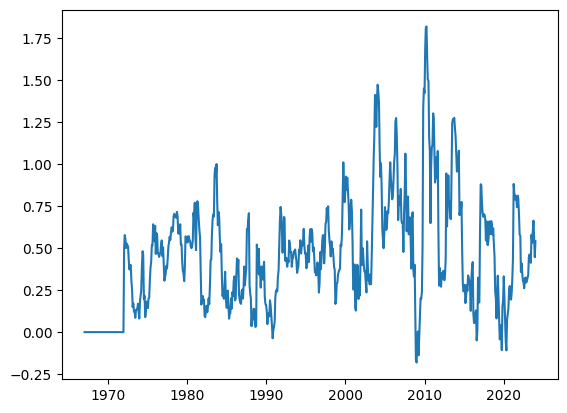

In [153]:
# compute the exposure to the market
strat_daily_beta = final_data.groupby('date')['beta_in_market'].sum()
plt.plot(strat_daily_beta)

In [154]:
# Here we calculate the weights in each industry

In [155]:
sic_map = pd.read_csv("SIC_to_Fama_French_industry.csv")
sic_map = sic_map[['SIC', 'FF_12']]

In [156]:
final_data = final_data.merge(sic_map, how='inner', left_on='siccd', right_on='SIC')
final_data

,date,permno,weight_in_BAB_final,beta,siccd,weight_in_MOM_final,weight_in_IV_final,sum_of_weights,beta_in_market,SIC,FF_12
0,1967-01-31,10006,NaN,1.373045,3743,NaN,NaN,NaN,NaN,3743,3
1,1967-01-31,10014,NaN,1.247586,3714,NaN,NaN,NaN,NaN,3714,2
2,1967-01-31,10057,NaN,1.527122,3541,NaN,NaN,NaN,NaN,3541,3
3,1967-01-31,10102,NaN,1.329974,2813,NaN,NaN,NaN,NaN,2813,5
4,1967-01-31,10137,NaN,0.616947,4911,NaN,NaN,NaN,NaN,4911,8
...,...,...,...,...,...,...,...,...,...,...,...
1108496,2023-12-29,93372,0.001328,1.092639,3531,-0.000126,0.000000,0.001202,0.001313,3531,3
1108497,2023-12-29,93373,-0.002807,2.192839,5621,-0.000006,0.000024,-0.002789,-0.006115,5621,9
1108498,2023-12-29,93374,-0.000248,1.242053,6361,0.000000,-0.000253,-0.000501,-0.000622,6361,11
1108499,2023-12-29,93423,-0.002763,2.143114,7389,0.000000,0.000000,-0.002763,-0.005921,7389,12


In [160]:
# compute the exposure to each industry
industry_weights = final_data.groupby(['date', 'FF_12'])['sum_of_weights'].sum().unstack()
industry_weights

FF_12,1,2,3,4,5,6,7,8,9,10,11,12
date,,,,,,,,,,,,
1967-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1967-02-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1967-03-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1967-04-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1967-05-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,0.146905,0.004991,0.140175,0.157643,0.040435,0.168039,-0.044139,0.203652,0.122182,0.191594,0.238595,0.038511
2023-09-29,0.127488,-0.000872,0.153231,0.196552,0.048083,0.224914,0.000393,0.212557,0.116465,0.169278,0.038807,0.102818
2023-10-31,0.119488,0.005234,0.083739,0.199960,0.038587,0.211453,-0.007145,0.240020,0.104232,0.151889,0.184973,0.057714


In [164]:
industry_weights.sum(axis=0)

FF_12
1      96.131434
2       3.263112
3      86.086055
4      33.588975
5      13.316454
6      67.686078
7       1.907604
8     200.366903
9      86.825642
10     37.003892
11    111.957870
12    103.002858
dtype: float64

In [ ]:
Industries =['NoDur',
 'Durbl',
 'Manuf',
 'Enrgy',
 'Chems',
 'BusEq',
 'Telcm',
 'Utils',
 'Shops',
 'Hlth',
 'Money',
 'Other']

In [167]:
industry_weights.columns

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='FF_12')

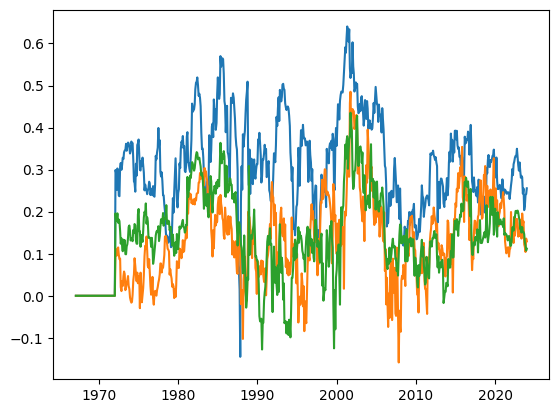

In [168]:
plt.plot(industry_weights[8], label = Industries[7])
plt.plot(industry_weights[9], label = Industries[8])
plt.plot(industry_weights[1], label = Industries[0])


In [169]:
returns

,date,R_BAB,R_IV,R_MOM,rf,EW_BAB_weight,EW_IV_weight,EW_MOM_weight,EW,RP_BAB_weight,RP_IV_weight,RP_MOM_weight,RP,MVE_BAB_weight,MVE_IV_weight,MVE_MOM_weight,MVE
0,1967-01-31,0.070885,0.159371,0.159371,0.003788,0.747359,0.747359,0.747359,0.286487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1967-02-28,0.017369,0.035770,0.035770,0.003737,0.747359,0.747359,0.747359,0.061805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1967-03-31,0.005893,0.014321,0.014321,0.003385,0.747359,0.747359,0.747359,0.021606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1967-04-28,0.019804,0.028545,0.028545,0.002877,0.747359,0.747359,0.747359,0.053893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1967-05-31,0.003044,0.024710,0.024710,0.002707,0.747359,0.747359,0.747359,0.035846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,2023-08-31,-0.012752,-0.003425,-0.003425,0.004463,0.747359,0.747359,0.747359,-0.020194,1.446744,0.541845,0.541845,-0.028992,3.740464,-1.372340,-1.372340,-0.038281
679,2023-09-29,-0.042908,0.022047,0.022047,0.004472,0.747359,0.747359,0.747359,-0.004667,1.440037,0.545199,0.545199,-0.044592,3.107807,-1.056012,-1.056012,-0.179894
680,2023-10-31,0.003602,-0.024331,-0.024331,0.004475,0.747359,0.747359,0.747359,-0.039235,1.443789,0.543323,0.543323,-0.028087,5.334328,-2.169273,-2.169273,0.124796
681,2023-11-30,0.037597,-0.000303,-0.000303,0.004455,0.747359,0.747359,0.747359,0.022112,1.434951,0.547742,0.547742,0.046800,14.585849,-6.795033,-6.795033,0.552509


In [175]:
industry_reuturns.index

DatetimeIndex(['1926-07-01', '1926-08-01', '1926-09-01', '1926-10-01',
               '1926-11-01', '1926-12-01', '1927-01-01', '1927-02-01',
               '1927-03-01', '1927-04-01',
               ...
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01', '2024-01-01', '2024-02-01',
               '2024-03-01', '2024-04-01'],
              dtype='datetime64[ns]', name='Date', length=1174, freq=None)

In [184]:
industry_weights['date'] = industry_weights.index
industry_weights['date'] = industry_weights['date'].apply(lambda x: x.strftime('%Y-%m'))
industry_weights['date'] = pd.to_datetime(industry_weights['date'])
industry_weights = industry_weights.set_index('date')
industry_weights.index

DatetimeIndex(['1967-01-01', '1967-02-01', '1967-03-01', '1967-04-01',
               '1967-05-01', '1967-06-01', '1967-07-01', '1967-08-01',
               '1967-09-01', '1967-10-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='date', length=683, freq=None)

In [185]:
industry_combined = industry_weights.merge(industry_reuturns, left_index=True, right_index=True, how='inner')
industry_combined

,1,2,3,4,5,6,7,8,9,10,...,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
1967-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.1147,0.0358,0.1042,0.1015,0.0624,0.0284,0.1178,0.0645,0.0903,0.1342
1967-02-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0156,-0.0007,0.0020,0.0625,0.0213,-0.0172,0.0325,0.0140,0.0022,-0.0058
1967-03-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0603,0.0361,0.0526,0.0537,0.0297,0.0153,0.0234,0.0786,0.0126,0.0589
1967-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0331,0.0167,0.0530,0.0779,0.0019,0.0188,0.0924,0.0446,0.0041,0.0293
1967-05-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.0337,-0.0242,-0.0464,-0.0435,-0.0567,-0.0411,-0.0463,-0.0528,-0.0242,-0.0192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,0.146905,0.004991,0.140175,0.157643,0.040435,0.168039,-0.044139,0.203652,0.122182,0.191594,...,-0.0221,0.0195,-0.0275,-0.0167,0.0014,-0.0529,-0.0040,-0.0022,-0.0361,-0.0298
2023-09-01,0.127488,-0.000872,0.153231,0.196552,0.048083,0.224914,0.000393,0.212557,0.116465,0.169278,...,-0.0730,0.0317,-0.0657,-0.0595,-0.0322,-0.0504,-0.0568,-0.0471,-0.0204,-0.0557
2023-10-01,0.119488,0.005234,0.083739,0.199960,0.038587,0.211453,-0.007145,0.240020,0.104232,0.151889,...,-0.0301,-0.0624,-0.0221,-0.0173,-0.0018,0.0112,0.0047,-0.0458,-0.0178,-0.0378
2023-11-01,0.107496,-0.013157,0.126589,0.181745,0.043520,0.206397,0.039547,0.241825,0.136002,0.135361,...,0.0973,-0.0129,0.0628,0.1194,0.0697,0.0508,0.0718,0.0587,0.1025,0.1073


In [188]:
industry_combined['hedge_return'] = 0
for i in range(12):
    industry_combined['hedge_return'] -= industry_combined.iloc[:,i] * industry_combined.iloc[:,i+12]
industry_combined

,1,2,3,4,5,6,7,8,9,10,...,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other,hedge_return
1967-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0358,0.1042,0.1015,0.0624,0.0284,0.1178,0.0645,0.0903,0.1342,0.000000
1967-02-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.0007,0.0020,0.0625,0.0213,-0.0172,0.0325,0.0140,0.0022,-0.0058,0.000000
1967-03-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0361,0.0526,0.0537,0.0297,0.0153,0.0234,0.0786,0.0126,0.0589,0.000000
1967-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0167,0.0530,0.0779,0.0019,0.0188,0.0924,0.0446,0.0041,0.0293,0.000000
1967-05-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.0242,-0.0464,-0.0435,-0.0567,-0.0411,-0.0463,-0.0528,-0.0242,-0.0192,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,0.146905,0.004991,0.140175,0.157643,0.040435,0.168039,-0.044139,0.203652,0.122182,0.191594,...,0.0195,-0.0275,-0.0167,0.0014,-0.0529,-0.0040,-0.0022,-0.0361,-0.0298,0.031202
2023-09-01,0.127488,-0.000872,0.153231,0.196552,0.048083,0.224914,0.000393,0.212557,0.116465,0.169278,...,0.0317,-0.0657,-0.0595,-0.0322,-0.0504,-0.0568,-0.0471,-0.0204,-0.0557,0.059133
2023-10-01,0.119488,0.005234,0.083739,0.199960,0.038587,0.211453,-0.007145,0.240020,0.104232,0.151889,...,-0.0624,-0.0221,-0.0173,-0.0018,0.0112,0.0047,-0.0458,-0.0178,-0.0378,0.033902
2023-11-01,0.107496,-0.013157,0.126589,0.181745,0.043520,0.206397,0.039547,0.241825,0.136002,0.135361,...,-0.0129,0.0628,0.1194,0.0697,0.0508,0.0718,0.0587,0.1025,0.1073,-0.091365


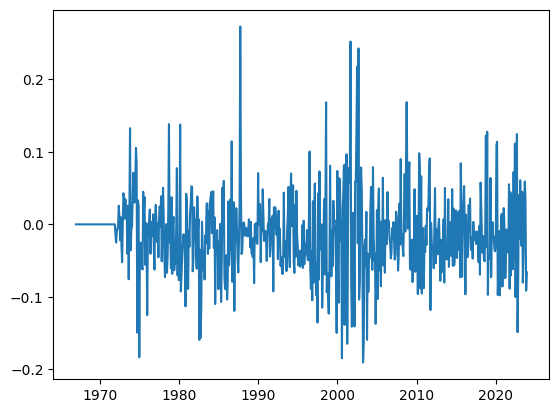

In [189]:
plt.plot(industry_combined['hedge_return'])

In [217]:
returns_copy = returns.copy()

In [221]:
returns_copy['date'] = returns_copy['date'].apply(lambda x: x.strftime('%Y-%m'))
returns_copy['date'] = pd.to_datetime(returns_copy['date'])

In [222]:
returns_copy.set_index('date', inplace=True)
returns_copy = returns_copy.merge(industry_combined['hedge_return'], left_index=True, right_index=True, how='inner')
returns_copy['return_after_hedge'] = returns_copy['RP'] + returns_copy['hedge_return']
returns_copy

,R_BAB,R_IV,R_MOM,rf,EW_BAB_weight,EW_IV_weight,EW_MOM_weight,EW,RP_BAB_weight,RP_IV_weight,RP_MOM_weight,RP,MVE_BAB_weight,MVE_IV_weight,MVE_MOM_weight,MVE,hedge_return,return_after_hedge
date,,,,,,,,,,,,,,,,,,
1967-01-01,0.070885,0.159371,0.159371,0.003788,0.747359,0.747359,0.747359,0.286487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1967-02-01,0.017369,0.035770,0.035770,0.003737,0.747359,0.747359,0.747359,0.061805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1967-03-01,0.005893,0.014321,0.014321,0.003385,0.747359,0.747359,0.747359,0.021606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1967-04-01,0.019804,0.028545,0.028545,0.002877,0.747359,0.747359,0.747359,0.053893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1967-05-01,0.003044,0.024710,0.024710,0.002707,0.747359,0.747359,0.747359,0.035846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,-0.012752,-0.003425,-0.003425,0.004463,0.747359,0.747359,0.747359,-0.020194,1.446744,0.541845,0.541845,-0.028992,3.740464,-1.372340,-1.372340,-0.038281,0.031202,0.002210
2023-09-01,-0.042908,0.022047,0.022047,0.004472,0.747359,0.747359,0.747359,-0.004667,1.440037,0.545199,0.545199,-0.044592,3.107807,-1.056012,-1.056012,-0.179894,0.059133,0.014541
2023-10-01,0.003602,-0.024331,-0.024331,0.004475,0.747359,0.747359,0.747359,-0.039235,1.443789,0.543323,0.543323,-0.028087,5.334328,-2.169273,-2.169273,0.124796,0.033902,0.005815


In [224]:
calculate_portfolio_metrics(returns_copy['return_after_hedge'], returns_copy['return_after_hedge'] - returns_copy['rf'])
print(f"Mean = {returns_copy['return_after_hedge'].mean():.2%}, Std Dev = {returns_copy['return_after_hedge'].std():.2%}, Sharpe Ratio = {returns_copy['return_after_hedge'].mean() / returns_copy['return_after_hedge'].std():.2f}\n")

Mean = 0.97%, Std Dev = 7.57%, Sharpe Ratio = 0.13

